In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper, psiam_tied_data_gen_wrapper_V2
import sys
import multiprocessing
from psiam_tied_no_dv_map_utils import cum_A_t_fn
from psiam_tied_no_dv_map_utils import rho_A_t_fn, cum_A_t_fn, rho_E_minus_small_t_NORM_fn
from psiam_tied_dv_map_utils import cum_E_t_fn
from tqdm import tqdm
from scipy.integrate import trapezoid
import random

In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

In [3]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

df = df[  df['LED_trial'] == 0 ]

# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))

# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)

In [4]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [5]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]
print(f'len of LED off rows: {len(df_1)}')
# remove trunc aborts
df_1 = df_1 [ ~( (df_1['abort_event']==3) & (df_1['timed_fix'] < 0.3) ) ]
print(f'len of LED off rows after removing trunc aborts: {len(df_1)}')

len of LED off rows: 66226
len of LED off rows after removing trunc aborts: 64326


In [6]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

In [7]:
vp_sample = vp.sample(int(1e6))[0]

In [8]:
V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04
t_A_aff = np.mean(vp_sample[:,2]) - t_motor

In [9]:
t_A_aff

-0.22648461252276914

# VBMC

## loglike fn

In [10]:
T_trunc_right_wrt_stim = 0.21
T_trunc_left_aborts = 0.3

In [11]:
def cum_psiam_tied_fn(t, V_A, theta_A, t_A_aff, t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_E_aff, K_max):
    c_A  = cum_A_t_fn(t - t_A_aff - t_motor, V_A, theta_A)
    c_E = cum_E_t_fn(t - t_E_aff - t_motor - t_stim, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, K_max)
    return c_A + c_E - (c_A * c_E)

In [12]:
def compute_loglike(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L):
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['response_poke']

    rt = timed_fix
    t_stim = intended_fix
    
    K_max = 10
    cum_1 = cum_psiam_tied_fn(T_trunc_left_aborts, V_A, theta_A, t_A_aff, t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_E_aff, K_max) 
    cum_2 = cum_psiam_tied_fn(t_stim + T_trunc_right_wrt_stim, V_A, theta_A, t_A_aff, t_motor, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_E_aff, K_max) 
    trunc_factor = cum_2 - cum_1 + 1e-30

    if rt < t_stim:
        likelihood = rho_A_t_fn(rt - t_A_aff - t_motor, V_A, theta_A)
    else:
        if rt - t_stim < T_trunc_right_wrt_stim:
            if choice == 3:
                likelihood = up_RTs_fit_fn(
                    [rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0,
                    theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max
                )[0]
            elif choice == 2:
                likelihood = down_RTs_fit_fn(
                    [rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0,
                    theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max
                )[0]
        else:
            likelihood = 0
                
    
    likelihood /= trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50

    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params


    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L)\
                                       for _, row in df_1.iterrows() if (row['timed_fix'] > row['intended_fix']) \
                                        and (row['response_poke'] in [2,3]))

    loglike = np.sum(all_loglike)
    return loglike

## Bounds

In [13]:
rate_lambda_bounds = [0.01, 0.2]
theta_E_bounds = [30, 60]
T_0_bounds = [0.1*(1e-3), 1*(1e-3)]


t_E_aff_bounds = [0.001, 0.1]
Z_E_bounds = [-10, 10]
L_bounds = [0.1, 1.99]

# ---
rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15*(1e-3), 0.5*(1e-3)]
theta_E_plausible_bounds = [40, 55]

t_E_aff_plausible_bounds = [0.01, 0.05]
Z_E_plausible_bounds = [-5, 5]
L_plausible_bounds = [0.5, 1.5]

## prior

In [14]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    L_logpdf = trapezoidal_logpdf(L, L_bounds[0], L_plausible_bounds[0], L_plausible_bounds[1], L_bounds[1])

    return rate_lambda_logpdf + T_0_logpdf + theta_E_logpdf + t_E_aff_logpdf + Z_E_logpdf + L_logpdf


## prior + loglike

In [15]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

## run vbmc

In [ ]:
lb = np.array([ rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
               t_E_aff_bounds[0], Z_E_bounds[0], L_bounds[0]])
ub = np.array([ rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
                t_E_aff_bounds[1], Z_E_bounds[1], L_bounds[1]])

plb = np.array([ rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], \
                t_E_aff_plausible_bounds[0], Z_E_plausible_bounds[0], L_plausible_bounds[0]])

pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], \
                t_E_aff_plausible_bounds[1], Z_E_plausible_bounds[1], L_plausible_bounds[1]])


np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])

t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])

x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0, t_E_aff_0, Z_E_0, L_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()

In [15]:
vbmc.save('right_trunc_with_choice.pkl', overwrite=True)

# Till HERE PYTHON FILE

In [17]:
with open('pkl_right_trunc_with_choice.pkl', 'rb') as f:
    vp = pickle.load(f)

In [18]:
vp = vp.vp

In [19]:
vp.stats

{'elbo': -2691101.231167353,
 'elbo_sd': 0.009207859092882796,
 'e_log_joint': -2691109.958426907,
 'e_log_joint_sd': 0.009207859092882796,
 'entropy': 8.727259553986421,
 'entropy_sd': 0.0,
 'stable': array(True),
 'I_sk': array([[-2691110.16885822, -2691109.24111361, -2691110.06642835,
         -2691109.8005375 , -2691109.46663084, -2691109.7287952 ,
         -2691109.65286255, -2691110.21022341, -2691109.65143898,
         -2691112.1852045 , -2691111.65493802, -2691110.91660788,
         -2691110.45478623, -2691111.25246475, -2691109.39218624,
         -2691109.53307635, -2691110.06113244, -2691109.49346823,
         -2691109.13399226, -2691109.93123648, -2691110.69192871,
         -2691110.43994459, -2691108.91090026, -2691109.62347293,
         -2691109.6318119 , -2691110.89823767, -2691109.70088207,
         -2691109.14138668, -2691110.65418882, -2691110.01794053,
         -2691110.17459669, -2691109.69460326, -2691108.79038733,
         -2691111.5279537 , -2691109.32610625, -269

## corner plots

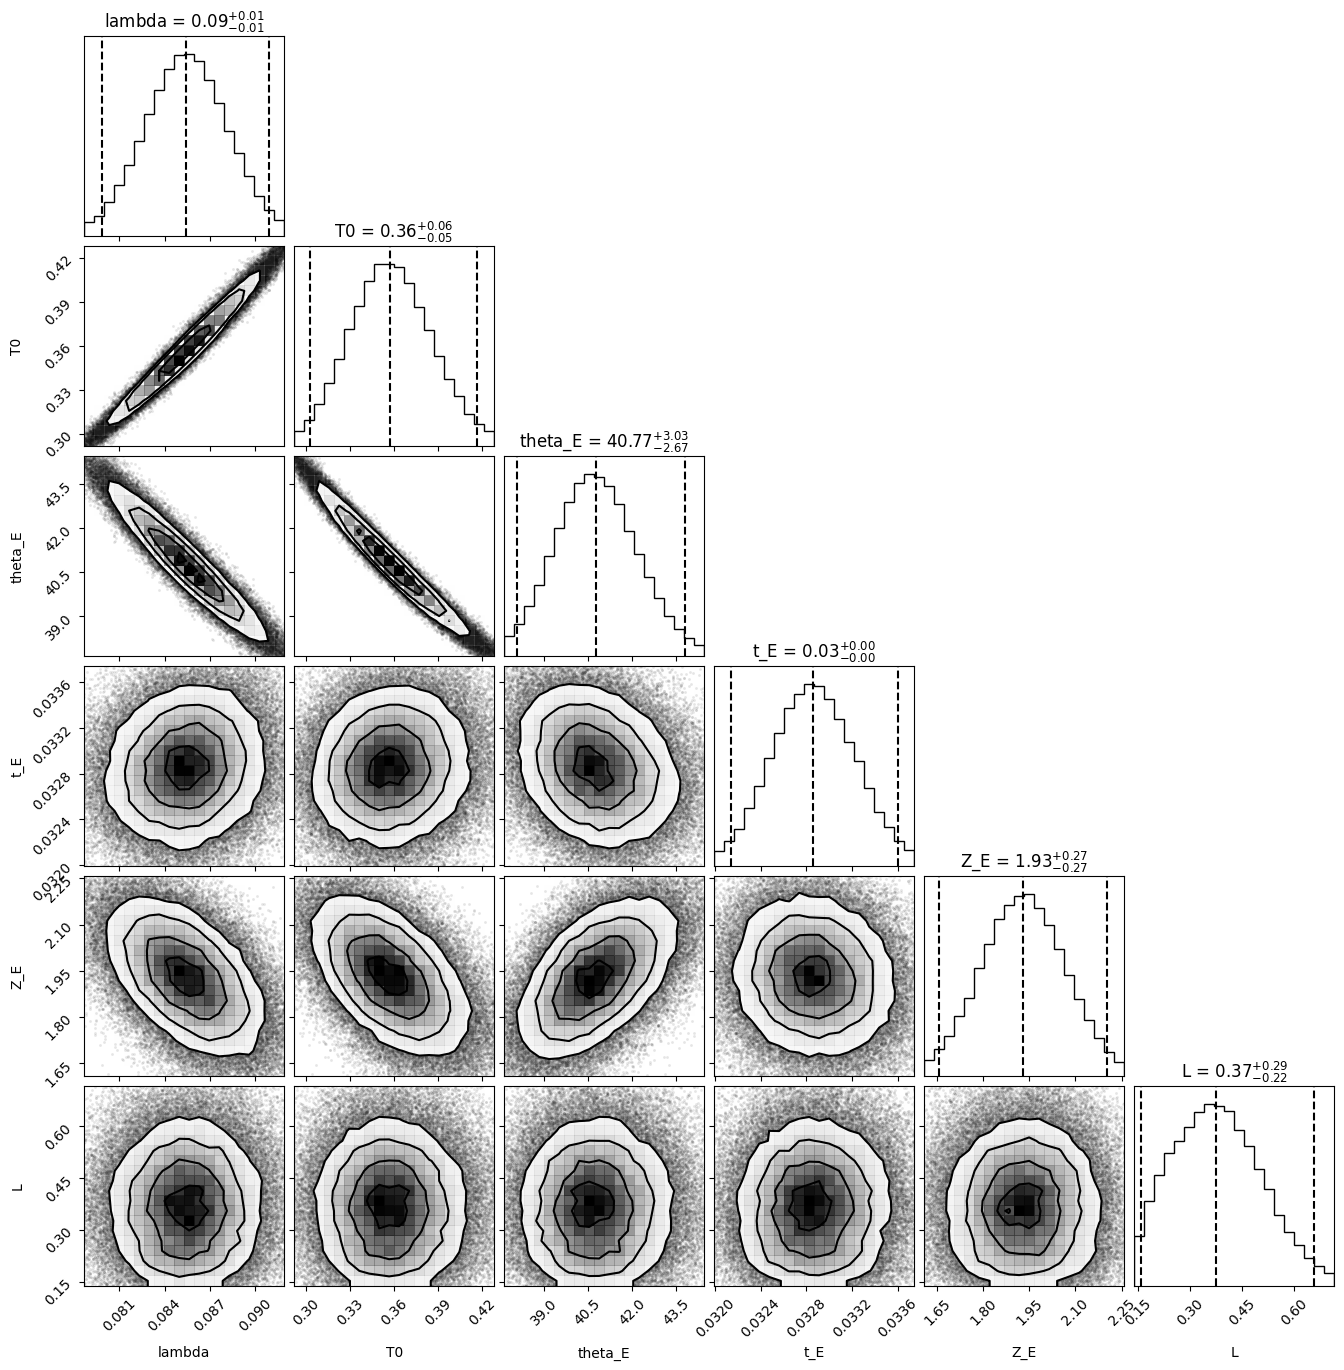

In [20]:
vp_samples = vp.sample(int(1e5))[0]
vp_samples[:,1] = vp_samples[:,1] * 1e3

param_labels = ['lambda', 'T0', 'theta_E', 't_E', 'Z_E', 'L']

percentiles = np.percentile(vp_samples, [1, 99], axis=0)

_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]


# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
);

# diagnose

## simulate data

In [21]:
lambda_times_theta_E = vp_samples[:,0] * vp_samples[:,2]
max_idx = np.argmax(lambda_times_theta_E)
print(f'max product  = {lambda_times_theta_E[max_idx]}')

max product  = 3.644302571843735


In [22]:
lambda_mean = vp_samples[max_idx, 0]
T0_mean = vp_samples[max_idx, 1] / 1e3
theta_E_mean = vp_samples[max_idx, 2]

In [23]:
print(f'lambda = {lambda_mean}')
print(f't0 = {T0_mean * 1000} ms')
print(f'theta E = {theta_E_mean}')

lambda = 0.08598003937003697
t0 = 0.3440168148891095 ms
theta E = 42.38544897798374


In [24]:
# lambda_mean = np.mean(vp_samples[:,0])
# T0_mean = np.mean(vp_samples[:,1]) / 1e3
# theta_E_mean = np.mean(vp_samples[:,2])

# t_E_aff_mean = np.mean(vp_samples[:,3])
# Z_E_mean = np.mean(vp_samples[:,4])
# L_mean = np.mean(vp_samples[:,5])

t_E_aff_mean = vp_samples[max_idx, 3]
Z_E_mean = vp_samples[max_idx, 4]
L_mean = vp_samples[max_idx, 5]


In [25]:
print(f'likelihood = {psiam_tied_loglike_fn([lambda_mean, T0_mean, theta_E_mean, t_E_aff_mean, Z_E_mean, L_mean]):.3f} ')

likelihood = -2691091.953 


In [27]:
N_print = 50_000 + 1
dt = 1e-4
N_sim = int(50_000 + 1)

t_stim_sampled = np.random.choice(df_1['intended_fix'], N_sim)

sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_V2)(V_A, theta_A, ABL_arr, ILD_arr, lambda_mean, T0_mean, theta_E_mean, Z_E_mean, t_A_aff, t_E_aff_mean, t_motor, L_mean, \
                                                                         t_stim_sampled[iter_num], iter_num, N_print, dt) for iter_num in range(N_sim)) 

# Generic class for diagnostics

In [29]:
class Diagnostics:
    """
    Remove truncated aborts by urself

    data frame with column names
    rt: RT wrt fixation
    t_stim: stimulus onset
    choice: 1 or -1
    ABL, ILD
    correct: 1 or 0
    """
    def __init__(self, data):
        self.data = data

    def plot_rtd_wrt_fix(self,bins):
        """
        return x and y for plotting
        """
        df = self.data.copy()
        rt_wrt_fix = df['rt']
        rt_wrt_fix_hist, _ = np.histogram(rt_wrt_fix, bins=bins, density=True)
        
        bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])

        return bin_centers, rt_wrt_fix_hist
    

    def plot_rtd_wrt_stim(self,bins):
        df = self.data.copy()
        rt_wrt_stim = df['rt'] - df['t_stim']
        rt_wrt_stim_hist, _ = np.histogram(rt_wrt_stim, bins=bins, density=True)
        
        bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])

        return bin_centers, rt_wrt_stim_hist

    def plot_tacho(self, bins):
        # prob of correct vs RT
        df = self.data.copy()
        df['RT_bin'] = pd.cut(df['rt'] - df['t_stim'], bins=bins, include_lowest=True)
        grouped_by_rt_bin = df.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
        grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)
        return grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean']
    
    def plot_chrono(self):
        # mean rt vs abs ILD for each ABL
        df = self.data.copy()
        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())
        all_ILD = all_ILD[all_ILD > 0] 

        abl_rt_dict = {}

        for ABL in all_ABL:
            per_ILD_rt = np.zeros_like(all_ILD)
            for idx, ILD in enumerate(all_ILD):
                filtered_df = df[ (df['ABL'] == ABL) \
                                            & (df['ILD'].isin([ILD, -ILD])) ]
                mean_rt = (filtered_df['rt'] - filtered_df['t_stim']).replace([np.nan, np.inf, -np.inf], np.nan).dropna().mean()
                per_ILD_rt[idx] = mean_rt
            abl_rt_dict[ABL] = per_ILD_rt
        
        return all_ILD, abl_rt_dict

    def plot_quantile(self):
        # 10 - 90 percentiles in steps of 20
        df = self.data.copy()
        df['rt_wrt_stim'] = df['rt'] - df['t_stim']

        abl_ild_quantiles = {}
        quantile_levels = [0.1, 0.3, 0.5, 0.7, 0.9]

        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())
        all_ILD = all_ILD[all_ILD > 0] 

        for abl in all_ABL:
            abl_ild_quantiles[abl] = {}
            for ild in all_ILD:
                filtered_df = df[(df['ABL'] == abl) & (df['ILD'].isin([ild, -ild]))]
                quantiles = filtered_df['rt_wrt_stim'].replace([np.nan, np.inf, -np.inf], np.nan).dropna().quantile(quantile_levels).tolist()
                abl_ild_quantiles[abl][ild] = quantiles

        return abl_ild_quantiles
    
    def plot_psycho(self):
        df = self.data.copy()
        prob_choice_dict = {}

        all_ABL = np.sort(df['ABL'].unique())
        all_ILD = np.sort(df['ILD'].unique())

        for abl in all_ABL:
            filtered_df = df[df['ABL'] == abl]
            prob_choice_dict[abl] = [sum(filtered_df[filtered_df['ILD'] == ild]['choice'] == 1) / len(filtered_df[filtered_df['ILD'] == ild]) for ild in all_ILD]

        return prob_choice_dict



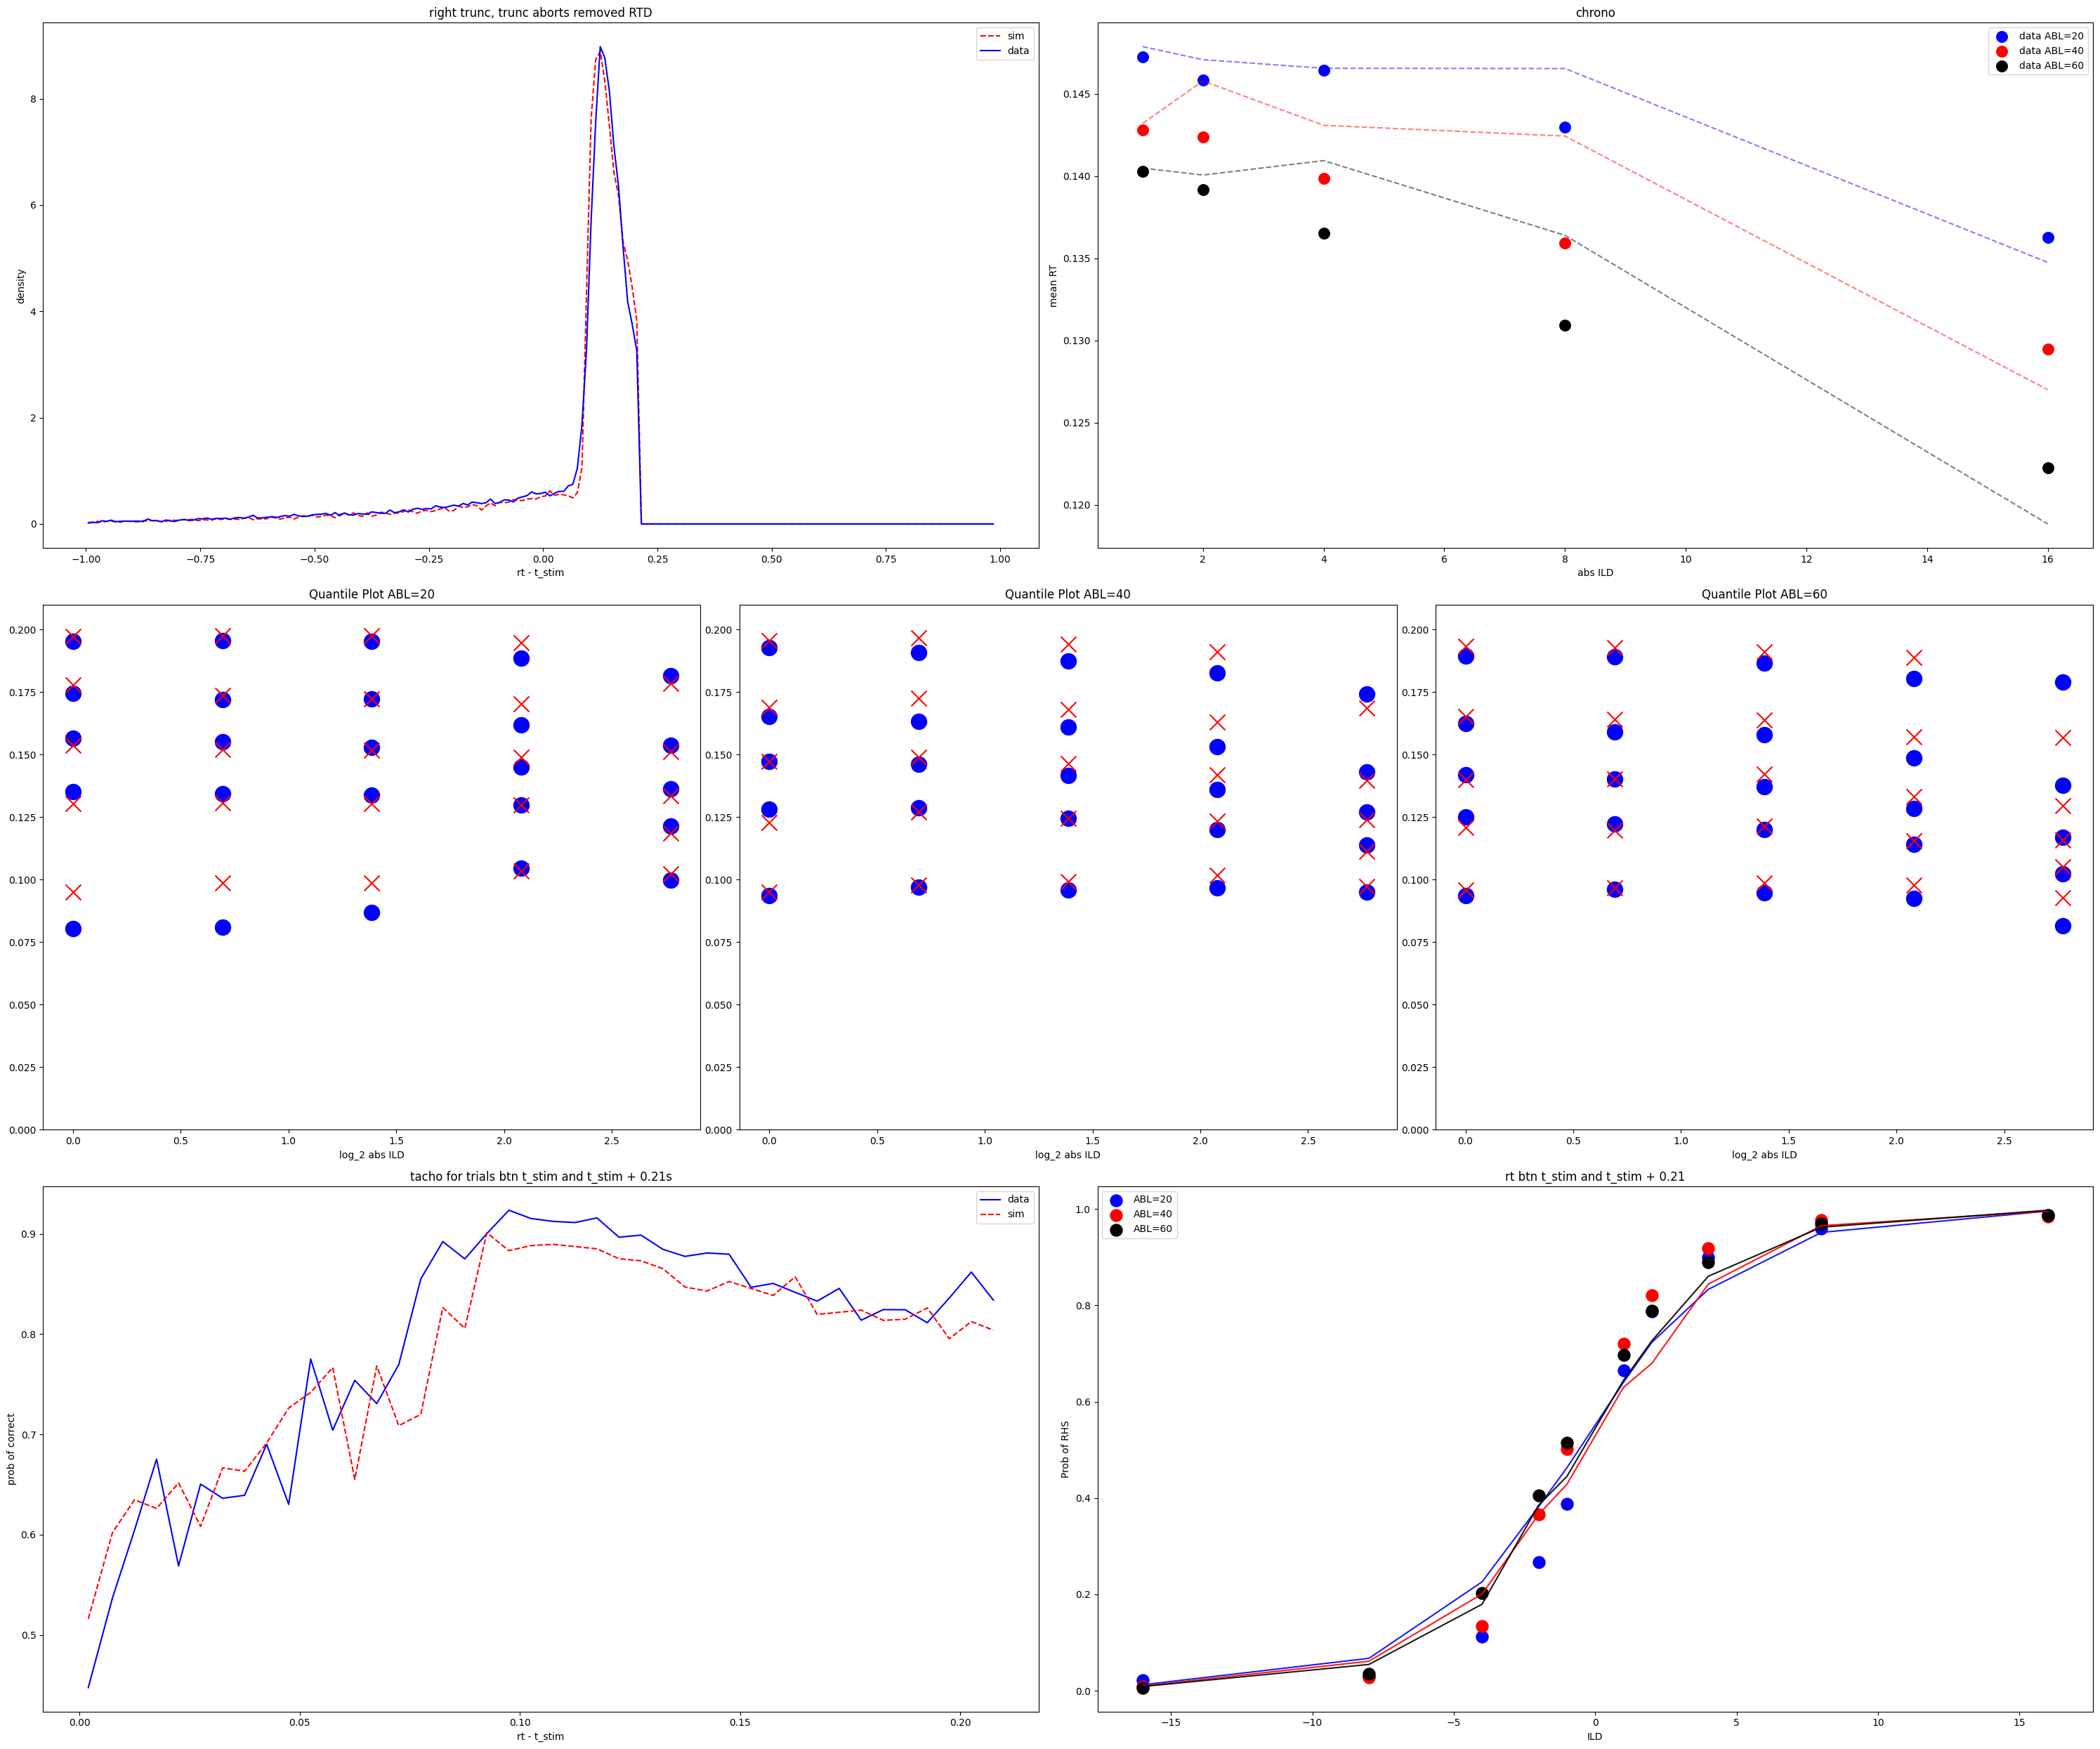

In [30]:
sim_results_1 = [res for res in sim_results if not (res['rt'] < res['t_stim'] and res['rt'] < T_trunc_left_aborts)]
sim_results_2 = [res for res in sim_results_1 if res['rt'] - res['t_stim'] < T_trunc_right_wrt_stim] 

df_led_off = df[ df['LED_trial'] == 0].copy()
df_led_off.loc[:,'rt'] = df_led_off['timed_fix']
df_led_off.loc[:,'t_stim'] = df_led_off['intended_fix']

df_led_off_trunc = df_led_off[ ~( (df_led_off['rt'] < df_led_off['t_stim']) & (df_led_off['rt'] < T_trunc_left_aborts)  ) ]
df_led_off_trunc_1 =  df_led_off_trunc[df_led_off_trunc['rt'] - df_led_off_trunc['t_stim'] < T_trunc_right_wrt_stim]

sim_diagnose_obj = Diagnostics(pd.DataFrame(sim_results_2))
data_diagnose_obj = Diagnostics(df_led_off_trunc_1)

fig = plt.figure(figsize=(30, 25))
gs = fig.add_gridspec(3, 2)

### PLOT 1
ax1 = fig.add_subplot(gs[0, 0])
bins = np.arange(-1, 1, 0.01)
x, y = sim_diagnose_obj.plot_rtd_wrt_stim(bins)
ax1.plot(x, y, label='sim', ls='--', color='r')
x, y = data_diagnose_obj.plot_rtd_wrt_stim(bins)
ax1.plot(x, y, label='data', color='b')
ax1.set_title('right trunc, trunc aborts removed RTD')
ax1.set_xlabel('rt - t_stim')
ax1.set_ylabel('density')
ax1.legend()

data_diagnose_obj_valid = Diagnostics(df_led_off_trunc_1[df_led_off_trunc_1['rt'] > df_led_off_trunc_1['t_stim']])
for d in sim_results_2:
    d['correct'] = 1 if d['ILD'] * d['choice'] > 0 else 0

sim_results_pd_valid = pd.DataFrame(sim_results_2)
sim_results_pd_valid_1 = sim_results_pd_valid[sim_results_pd_valid['rt'] > sim_results_pd_valid['t_stim']]

sim_diagnose_obj_valid = Diagnostics(sim_results_pd_valid_1)

### PLOT 2
ax2 = fig.add_subplot(gs[0, 1])
ABL_colors = {20: 'b', 40: 'r', 60: 'k'}
x, sim_chrono = sim_diagnose_obj_valid.plot_chrono()
for ABL in sim_chrono.keys():
    ax2.plot(x, sim_chrono[ABL], color=ABL_colors[ABL], alpha=0.5, ls='--')

x, data_chrono = data_diagnose_obj_valid.plot_chrono()
for ABL in data_chrono.keys():
    ax2.scatter(x, data_chrono[ABL], label=f'data ABL={ABL}', color=ABL_colors[ABL], marker='.', s=500)
ax2.legend()
ax2.set_xlabel('abs ILD')
ax2.set_ylabel('mean RT')
ax2.set_title('chrono')

### PLOT 3
gs_row1 = gs[1, :].subgridspec(1, 3)
for idx, ABL in enumerate(data_diagnose_obj_valid.plot_quantile().keys()):
    ax = fig.add_subplot(gs_row1[0, idx])

    data_q = data_diagnose_obj_valid.plot_quantile()
    sim_q = sim_diagnose_obj_valid.plot_quantile()
    all_ild = data_q[ABL].keys()
    for ild in all_ild:
        ax.scatter(np.log(ild*np.ones_like(data_q[ABL][ild])), data_q[ABL][ild], color='b', s=250)
        ax.scatter(np.log(ild*np.ones_like(sim_q[ABL][ild])), sim_q[ABL][ild], marker='x', color='r', s=250)
    ax.set_title(f'Quantile Plot ABL={ABL}')
    ax.set_xlabel('log_2 abs ILD')
    ax.set_ylim(0, 0.21)




### PLOT 4
ax4 = fig.add_subplot(gs[2, 0])
bins = np.arange(0, 0.3, 0.005)
x, data_tacho = data_diagnose_obj_valid.plot_tacho(bins)
ax4.plot(x, data_tacho, label='data', color='b')
x, sim_tacho = sim_diagnose_obj_valid.plot_tacho(bins)
ax4.plot(x, sim_tacho, label='sim', color='r', ls='--')
ax4.legend()
ax4.set_xlabel('rt - t_stim')
ax4.set_ylabel('prob of correct')
ax4.set_title('tacho for trials btn t_stim and t_stim + 0.21s')

### PLOT 5
ax5 = fig.add_subplot(gs[2, 1])
data_psycho = data_diagnose_obj_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
sim_psycho = sim_diagnose_obj_valid.plot_psycho()
for ABL in all_ABL:
    ax5.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax5.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])
ax5.set_xlabel('ILD')
ax5.set_ylabel('Prob of RHS')
ax5.set_title('rt btn t_stim and t_stim + 0.21')
ax5.legend()

plt.tight_layout()
plt.show()


# stim wise distr

In [31]:
data_only_valid_1 = df_led_off_trunc_1[df_led_off_trunc_1['rt'] > df_led_off_trunc_1['t_stim']]
sim_results_pd_valid_1.columns

Index(['choice', 'rt', 'is_act', 'ABL', 'ILD', 't_stim', 'correct'], dtype='object')

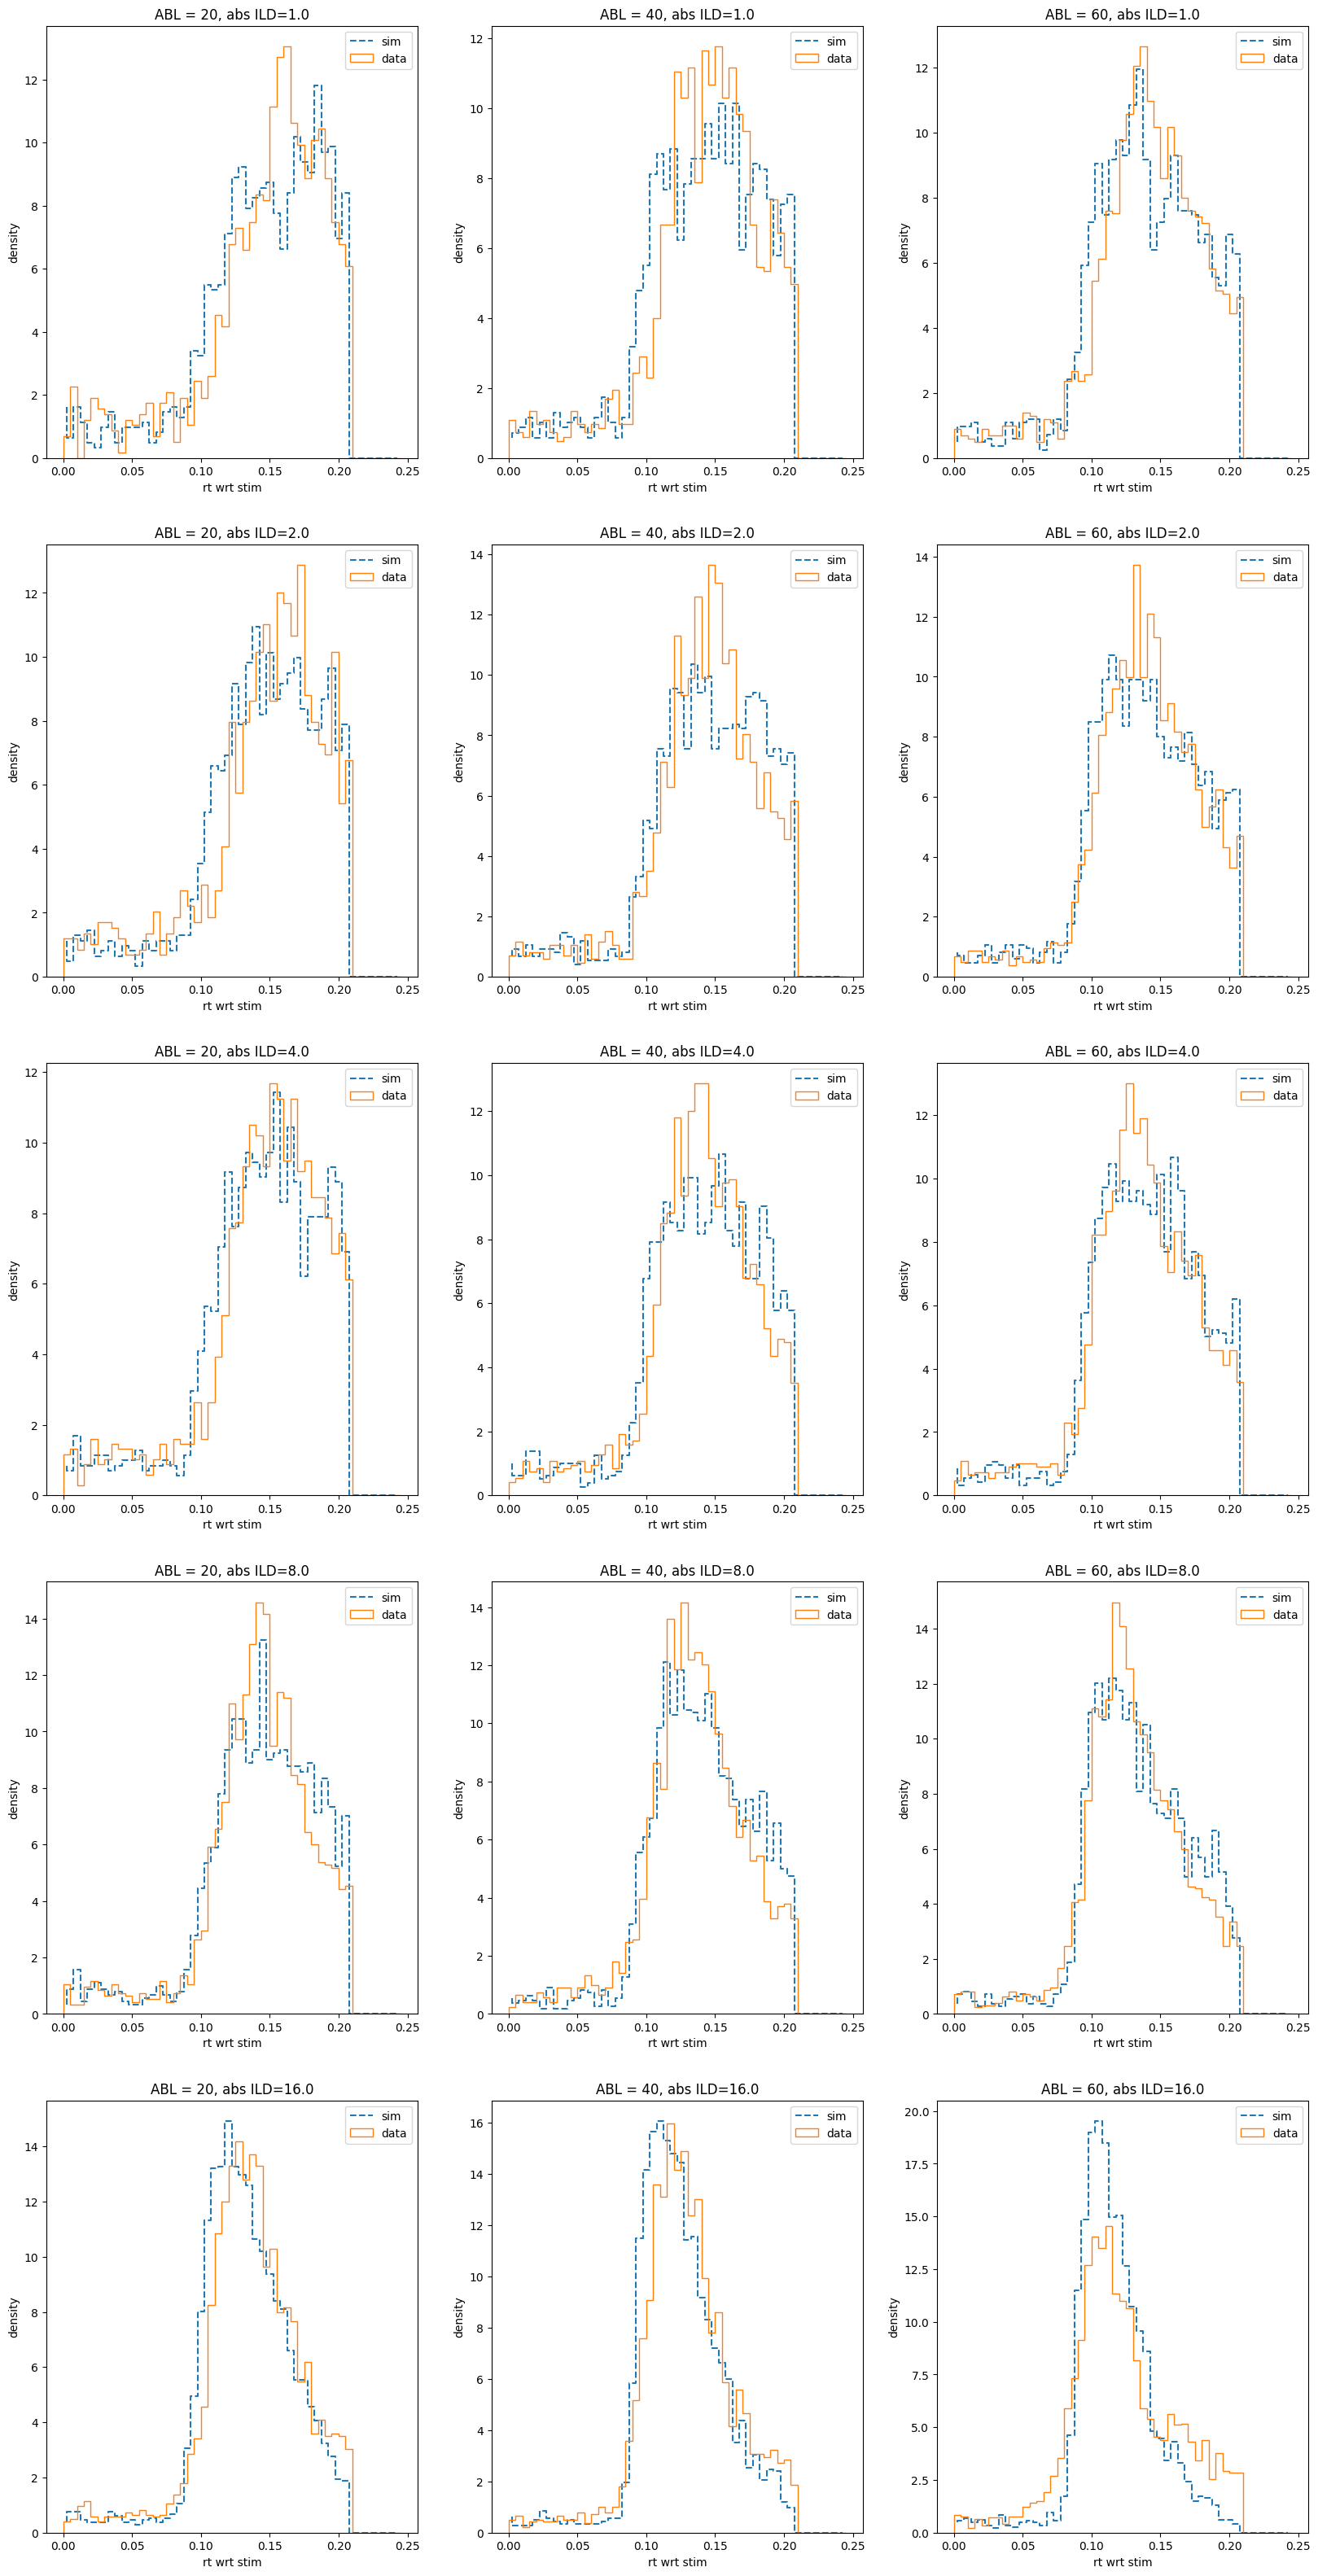

In [32]:
pos_ILD = all_ILD[ all_ILD > 0]
f = 1
bins = np.arange(0, 0.25, 0.005)
plt.figure(figsize=(20, 40))
for ILD in pos_ILD:
    for ABL in ABL_arr:
        plt.subplot(len(pos_ILD), len(ABL_arr), f)

        sim_pd = sim_results_pd_valid_1[(sim_results_pd_valid_1['ABL'] == ABL) & (sim_results_pd_valid_1['ILD'].isin([ILD, -ILD]))]
        sim_rt = sim_pd['rt'] - sim_pd['t_stim']

        data_pd = data_only_valid_1[ (data_only_valid_1['ABL'] == ABL) & (data_only_valid_1['ILD'].isin([ILD, -ILD]))]
        data_rt = data_pd['rt'] - data_pd['t_stim']

        # plt.hist(sim_rt, bins=bins, density=True, histtype='step', linestyle='--', color=ABL_colors[ABL])
        sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
        t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
        plt.step(t_pts,sim_rt_hist, linestyle='--', label='sim')

        plt.hist(data_rt, bins=bins, density=True, histtype='step', label='data')

        plt.xlabel('rt wrt stim')
        plt.ylabel('density')
        plt.legend()
        plt.title(f'ABL = {ABL}, abs ILD={ILD}')
        f += 1

# tacho to find sesnory delay

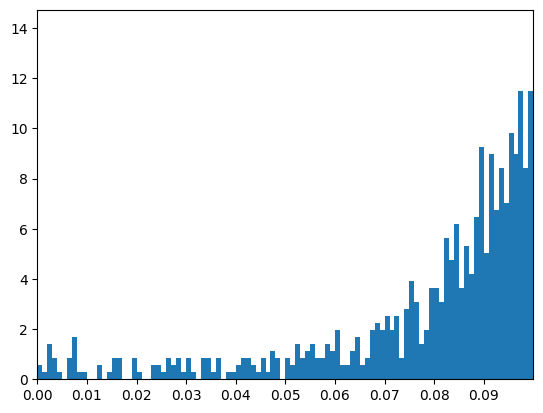

In [33]:
df_led_off = df[ df['LED_trial'] == 0].copy()
df_led_off.loc[:,'rt'] = df_led_off['timed_fix']
df_led_off.loc[:,'t_stim'] = df_led_off['intended_fix']
df_led_off_valid = df_led_off[ df_led_off['rt'] > df_led_off['t_stim'] ]

ABL = 60; ILD = 16
df_led_off_valid_ABL_ILD = df_led_off_valid[ (df_led_off_valid['ABL'] == ABL) & (df_led_off_valid['ILD'].isin([ILD, -ILD])) ]

bins=np.arange(0, 1, 0.001)
plt.hist(df_led_off_valid_ABL_ILD['rt']-df_led_off_valid_ABL_ILD['t_stim'], bins=bins, density=True);
plt.xlim(0, 0.1)
xticks = np.arange(0, 0.1, 0.01)
plt.xticks(xticks);

# param play

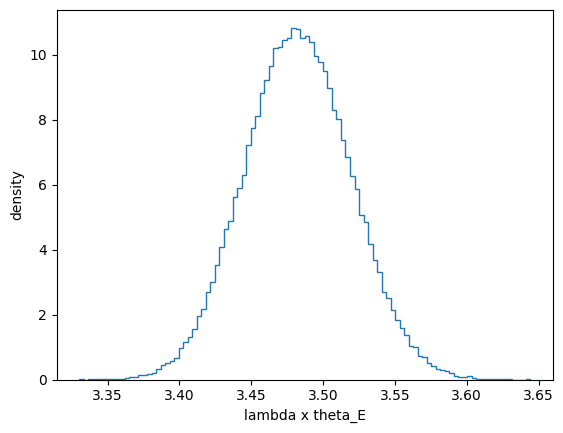

In [34]:
lam_times_theta = vp_samples[:,0] * vp_samples[:,2]
plt.hist(lam_times_theta, density=True, bins=100, histtype='step');
plt.xlabel('lambda x theta_E')
plt.ylabel('density');

In [35]:
max(vp_samples[:,0]) * max(vp_samples[:,2])
lambda_mean * theta_E_mean

3.644302571843735

# see fraction of different sets of trials

In [36]:
############ trunc ABORTS  ##########

# --- sim---
# num_aborts = np.sum([1 for res in sim_results if res['rt'] < res['t_stim'] and res['rt'] > 0.3])
num_aborts = np.sum([1 for res in sim_results if res['rt'] < res['t_stim']])

frac_aborts = num_aborts / len(sim_results)
print(f'sim frac aborts: {frac_aborts}')

# --- data ---
data_df = df.copy();
data_df_led_off = data_df[ data_df['LED_trial'] == 0 ]
data_df_trunc_aborts = data_df_led_off[ (data_df_led_off['timed_fix'] < data_df_led_off['intended_fix']) & (data_df_led_off['timed_fix'] > 0.3) ]
frac_aborts_data = len(data_df_trunc_aborts) / len(data_df_led_off)
print(f'data frac aborts: {frac_aborts_data}')

# -- theory ---
N_sim = 100_000
t_stim_sampled = np.random.choice(df['intended_fix'], N_sim)
def compute_trunc_frac_aborts_fn(t_stim):
    trunc_factor = 1 - cum_A_t_fn(0.3 - t_A_aff - t_motor, V_A, theta_A)
    frac_aborts = cum_A_t_fn(t_stim - t_A_aff - t_motor, V_A, theta_A) / (trunc_factor + 1e-10)
    return frac_aborts


results = Parallel(n_jobs=30)(delayed(compute_trunc_frac_aborts_fn)(t_stim) for t_stim in t_stim_sampled)
frac_aborts_theory = np.mean(results)
print(f'theory frac aborts: {frac_aborts_theory}')

sim frac aborts: 0.1364172716545669
data frac aborts: 0.12307854921027996
theory frac aborts: 0.13867520753787344


# truncated RT wrt stim

len of data_df: 66226
len of data_df: 64326


(-1.0, 0.3)

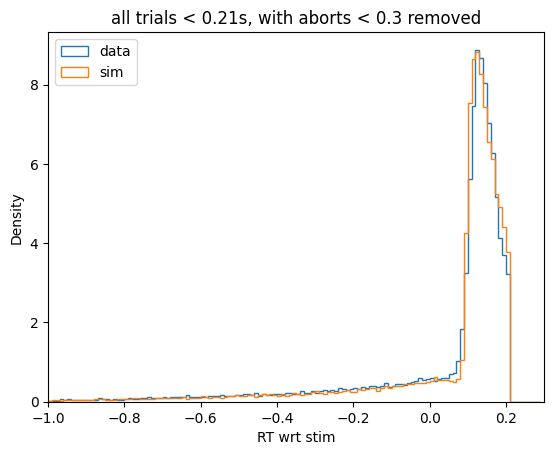

In [37]:
data_df = df.copy()
data_df = data_df[ data_df['LED_trial'] == 0]


data_df.loc[:, 'rt_wrt_stim'] = df['timed_fix'] - df['intended_fix']
print(f'len of data_df: {len(data_df)}')
data_df = data_df[ ~((data_df['abort_event'] == 3) & (data_df['timed_fix'] < 0.3)) ]
print(f'len of data_df: {len(data_df)}')

right_trunc_rt_wrt_stim = data_df[ (data_df['rt_wrt_stim'] < T_trunc_right_wrt_stim) ]['rt_wrt_stim']
bins = np.arange(-2, 0.3, 0.01)
plt.hist(right_trunc_rt_wrt_stim, bins=bins, density=True, label='data', histtype='step');

# sim
right_truncated_rt_wrt_stim_SIM = [res['rt'] - res['t_stim'] for res in sim_results if  \
                                    res['rt'] - res['t_stim'] < T_trunc_right_wrt_stim and \
                                        not (res['rt'] < res['t_stim'] and res['rt'] < 0.3)]
plt.hist(right_truncated_rt_wrt_stim_SIM, bins=bins, density=True, label='sim', histtype='step');
plt.legend();
plt.xlabel('RT wrt stim');
plt.ylabel('Density');
plt.title('all trials < 0.21s, with aborts < 0.3 removed')
plt.xlim(-1,0.3)

# is there a issue due to aligning to t_stim, see wrt fix

In [38]:
V_A, theta_A, t_A_aff, t_motor

(1.596338657170796, 2.5315383174441486, -0.22648461252276914, 0.04)

In [39]:
N_sim = 100_000
t_stim_sampled = np.random.choice(df_1['intended_fix'], N_sim)
t_pts = np.arange(0, 2, 0.05)
pro_pdf_vs_t_stim = np.zeros((N_sim, len(t_pts)))
def compute_pdf(t_stim):
    pro_pdf = np.zeros_like(t_pts)
    if t_stim < 0.3:
        return np.nan * np.zeros_like(t_pts)
    for t_id, t in enumerate(t_pts):
        if t < 0.3 or t > t_stim:
            pro_pdf[t_id] = 0
        else:
            pro_pdf[t_id] = rho_A_t_fn(t - t_A_aff, V_A, theta_A)

    return pro_pdf 

def compute_cdf(t_stim):
    area =  cum_A_t_fn(t_stim - t_A_aff, V_A, theta_A) - cum_A_t_fn(0.3 - t_A_aff, V_A, theta_A)
    if area < 0:
        area = np.nan
    return area

In [40]:
results = Parallel(n_jobs=30)(delayed(compute_pdf)(t_stim) for t_stim in tqdm(t_stim_sampled))

100%|██████████| 100000/100000 [00:00<00:00, 148567.13it/s]


In [41]:
results_cdf = Parallel(n_jobs=30)(delayed(compute_cdf)(t_stim) for t_stim in tqdm(t_stim_sampled))

100%|██████████| 100000/100000 [00:00<00:00, 269701.89it/s]


In [42]:
results_cdf_np = np.array(results_cdf)
# remove nan
results_cdf_no_nan = results_cdf_np[~np.isnan(results_cdf_np)]
np.mean(results_cdf_no_nan)

0.17624727843040594

In [43]:
pro_pdf_np = np.array(results)
pro_pdf_np_mean = np.nanmean(pro_pdf_np, axis=0)
print(f'area under the curve: {np.trapz(pro_pdf_np_mean, t_pts)}')  

area under the curve: 0.1802841869963945


In [44]:
data_df = df.copy()
data_df = data_df[ data_df['LED_trial'] == 0]
data_df_aborts = data_df[data_df['abort_event'] == 3]
data_df_trunc_aborts_rt_wrt_fix = data_df_aborts[ data_df_aborts['timed_fix'] > 0.3 ]['timed_fix']
frac_of_aborts = len(data_df_trunc_aborts_rt_wrt_fix) / len(data_df) 
print(f'frac of aborts: {frac_of_aborts}')

frac of aborts: 0.12307854921027996


area under pro_pdf_np_mean: 0.1802841869963945
area under data_aborts_hist: 0.12307098910283461
area under sim_hist: 0.12893738707484664


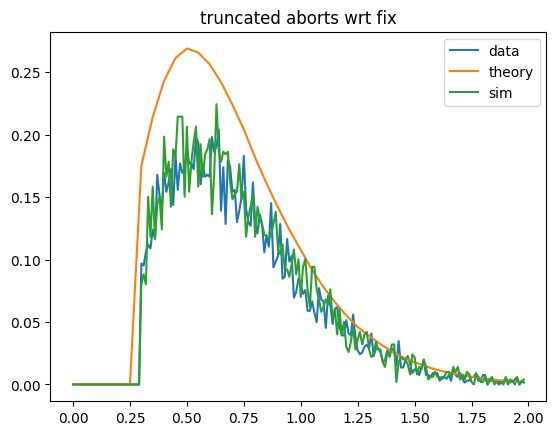

In [45]:
bins = np.arange(0, 2, 0.01)
data_aborts_hist, _ = np.histogram(data_df_trunc_aborts_rt_wrt_fix, bins=bins, density=True)
data_aborts_hist *= frac_of_aborts

plt.plot(bins[:-1], data_aborts_hist, label='data')
plt.plot(t_pts, pro_pdf_np_mean, label='theory');

print(f'area under pro_pdf_np_mean: {np.trapz(pro_pdf_np_mean, t_pts)}')    
print(f'area under data_aborts_hist: {np.trapz(data_aborts_hist, bins[:-1])}')

trunc_aborts_wrt_fix = [res['rt'] for res in sim_results if res['rt'] < res['t_stim'] and res['rt'] > 0.3]
sim_hist, _ = np.histogram(trunc_aborts_wrt_fix, bins=bins, density=True)
sim_hist *= len(trunc_aborts_wrt_fix) / len(sim_results)
print(f'area under sim_hist: {np.trapz(sim_hist, bins[:-1])}')
plt.plot(bins[:-1], sim_hist, label='sim');
plt.legend();
plt.title('truncated aborts wrt fix');


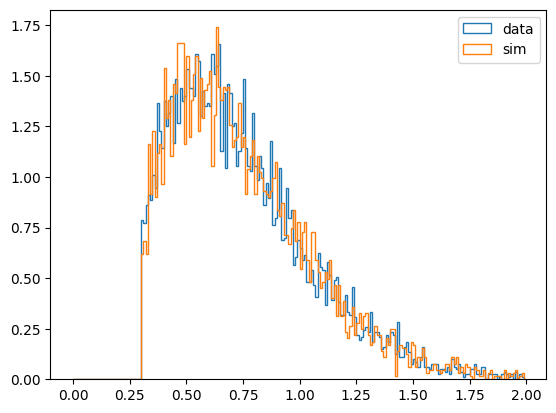

In [46]:
# aborts > 0.3
data_df = df.copy()
data_df = data_df[ data_df['LED_trial'] == 0]
data_df_aborts = data_df[data_df['abort_event'] == 3]
data_df_trunc_aborts_rt_wrt_fix = data_df_aborts[ data_df_aborts['timed_fix'] > 0.3 ]['timed_fix']


bins = np.arange(0, 2, 0.01);
plt.hist(data_df_trunc_aborts_rt_wrt_fix, bins=bins, density=True, label='data', histtype='step');

# sim
trunc_aborts_wrt_fix = [res['rt'] for res in sim_results if res['rt'] < res['t_stim'] and res['rt'] > 0.3]
plt.hist(trunc_aborts_wrt_fix, bins=bins, density=True, label='sim', histtype='step');
plt.legend();

## valid rt wrt stim

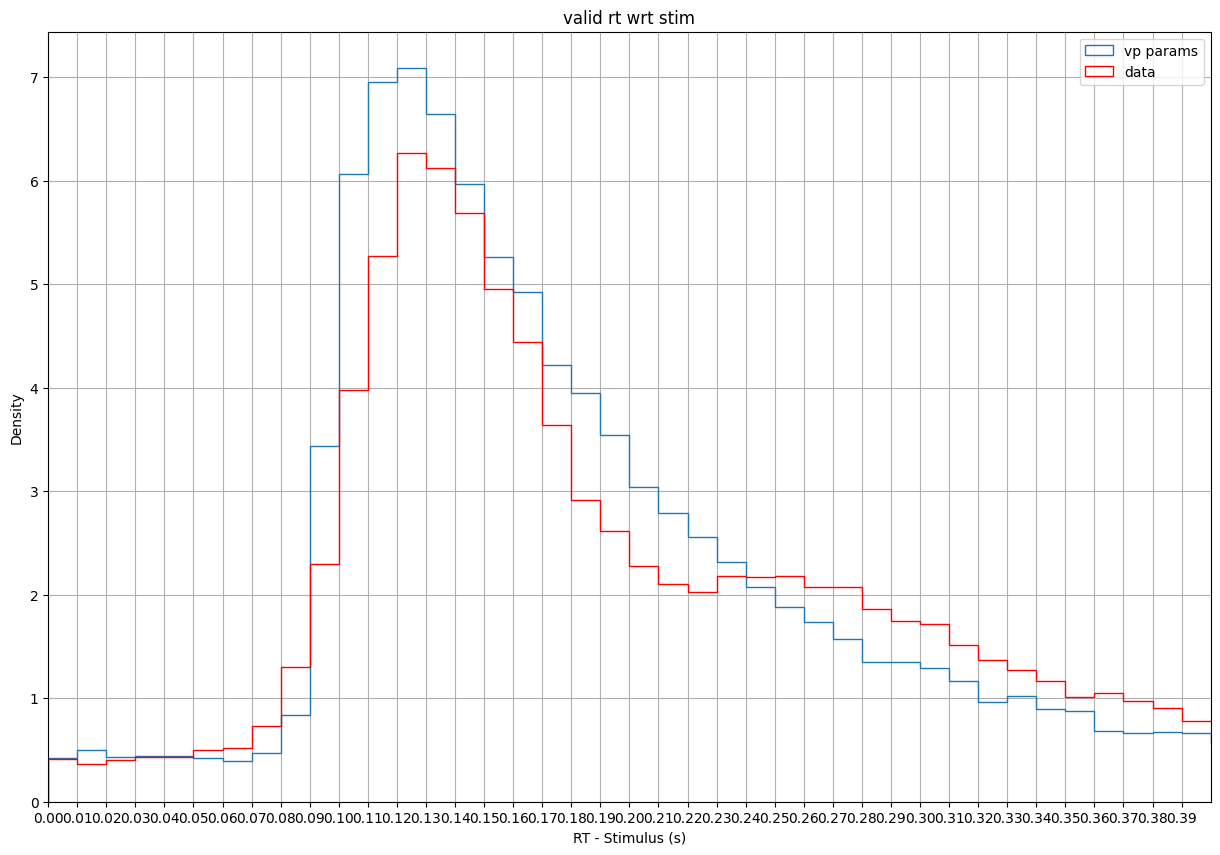

In [47]:
plt.figure(figsize=(15,10))
rt_wrt_stim = [res['rt'] - res['t_stim'] for res in sim_results if res['rt'] > res['t_stim']]
bins = np.arange(0, 2, 0.01)
plt.hist(rt_wrt_stim, bins=bins, density=True, histtype='step', label='vp params');

data_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']
plt.hist(data_rt_wrt_stim, bins=bins, density=True, histtype='step', color='red', label='data');
plt.xlabel('RT - Stimulus (s)');    
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt stim')
# plt.xlim(-1,1)
plt.grid(True)
plt.xlim(0,0.4)
xticks = np.arange(0, 0.4, 0.01)
plt.xticks(xticks, [f'{x:.2f}' for x in xticks]);

## valid rt wrt fix

Text(0.5, 1.0, 'valid rt wrt fix')

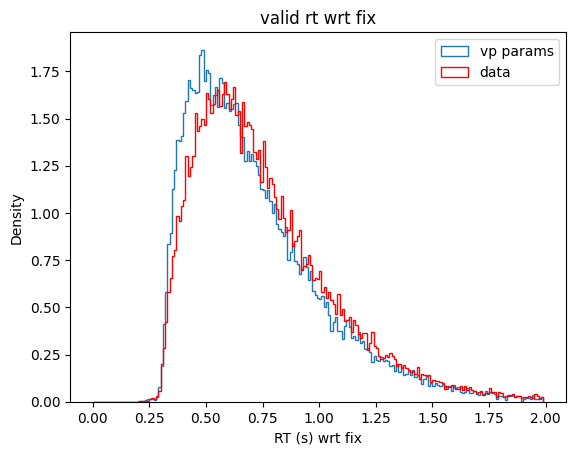

In [48]:
rt = [res['rt'] for res in sim_results if res['rt'] > res['t_stim']]
data_rt = df_1['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(data_rt, bins=bins, density=True, histtype='step', color='red', label='data');

plt.xlabel('RT (s) wrt fix');
plt.ylabel('Density');
plt.legend();
plt.title('valid rt wrt fix')


## all rt wrt fix

Text(0.5, 1.0, 'all rt inclding aborts wrt fix')

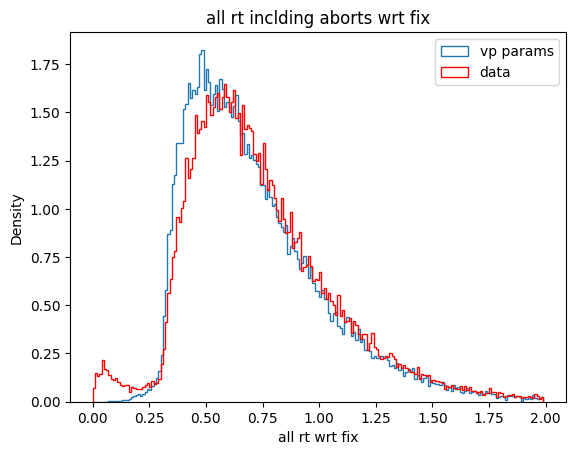

In [49]:
all_rt = [res['rt'] for res in sim_results]
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt inclding aborts wrt fix')

# all rt wrt fix, trunc aborts removed

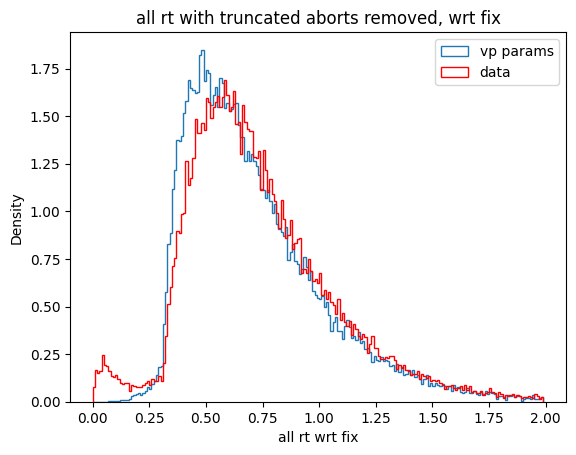

In [50]:
all_rt = [res['rt'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix']

bins = np.arange(0, 2, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt fix')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt fix');

## all rt wrt stim

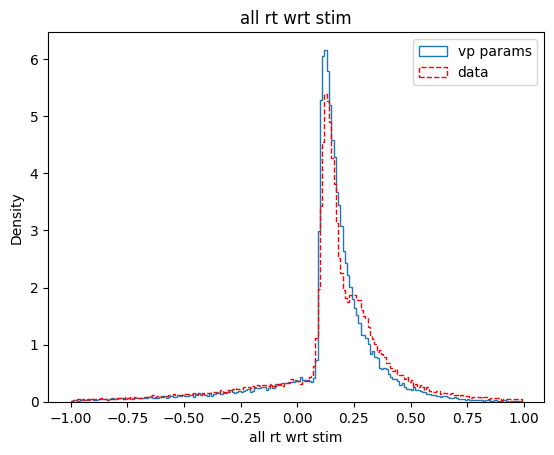

In [51]:
all_rt = [res['rt'] - res['t_stim'] for res in sim_results]
df_led_off = df [ df['LED_trial'] == 0]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-1, 1, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data', ls='--');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('all rt wrt stim');

# all rt wrt stim trunc aborts removed

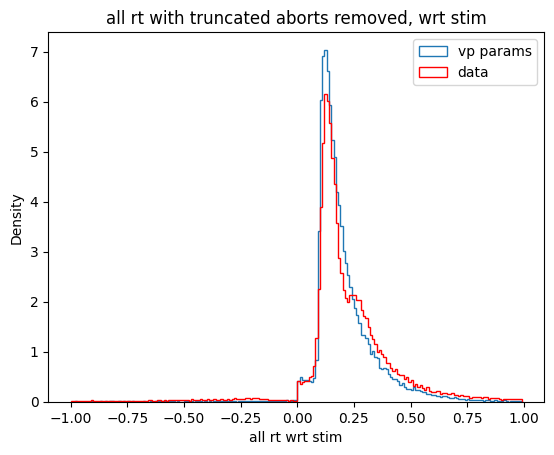

In [52]:
all_rt = [res['rt'] - res['t_stim'] for res in sim_results if not(res['rt'] < res['t_stim'] and res['rt'] > 0.3)]

df_led_off = df [ df['LED_trial'] == 0]
df_led_off = df_led_off[~((df_led_off['timed_fix'] > 0.3) & (df_led_off['timed_fix'] < df_led_off['intended_fix']))]
df_led_off_all_rt = df_led_off['timed_fix'] - df_led_off['intended_fix']

bins = np.arange(-1, 1, 0.01)
plt.hist(all_rt, bins=bins, density=True, histtype='step', label='vp params');
plt.hist(df_led_off_all_rt, bins=bins, density=True, histtype='step', color='red', label='data');
plt.legend();
plt.xlabel('all rt wrt stim')
plt.ylabel('Density');
plt.title('all rt with truncated aborts removed, wrt stim');

## psychometric

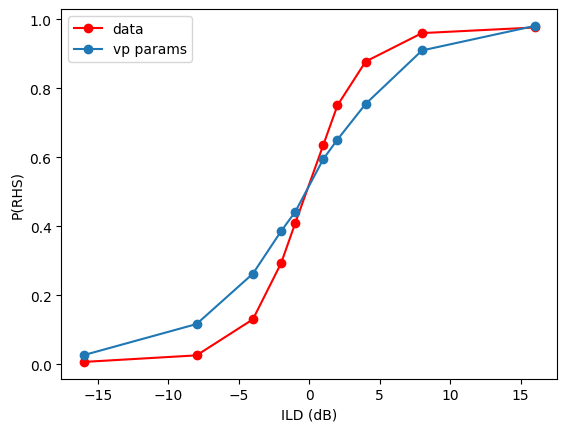

In [27]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ]
sim_results_valid_df = sim_results_valid_df.copy()

sim_results_valid_df.loc[:, 'RHS'] = (sim_results_valid_df['choice'] > 0).astype(int)
sim_grouped = sim_results_valid_df.groupby('ILD')['RHS'].mean().reset_index()

# data
data_df = df_1.copy()
data_df.loc[:, 'RHS'] = (data_df['response_poke'] == 3).astype(int)
data_grouped = data_df.groupby('ILD')['RHS'].mean().reset_index()

plt.plot(data_grouped['ILD'], data_grouped['RHS'], label='data', marker='o', color='red');
plt.plot(sim_grouped['ILD'], sim_grouped['RHS'], label='vp params', marker='o');
plt.xlabel('ILD (dB)');
plt.ylabel('P(RHS)');
plt.legend();

## tachometric

/tmp/ipykernel_28308/464138592.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sim_grouped = sim_results_valid_df.groupby('rt_bin')['correct'].mean().reset_index()
/tmp/ipykernel_28308/464138592.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_grouped = data_df.groupby('rt_bin')['correct'].mean().reset_index()


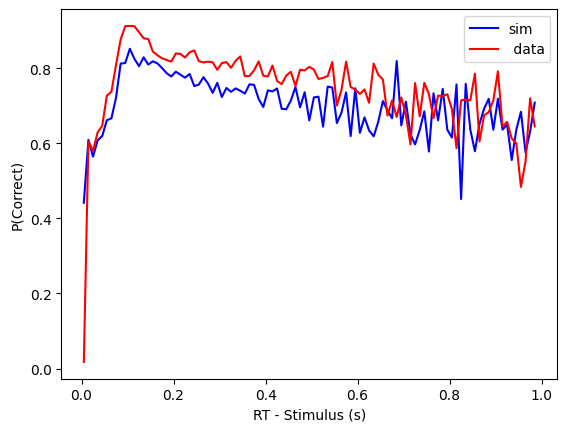

In [28]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

# sim results
sim_results_df = pd.DataFrame(sim_results)
sim_results_valid_df = sim_results_df[ sim_results_df['rt'] > sim_results_df['t_stim'] ].copy()
sim_results_valid_df.loc[:, 'correct'] = (sim_results_valid_df['choice'] * sim_results_valid_df['ILD'] > 0)
sim_results_valid_df.loc[:, 'rt_wrt_stim'] = sim_results_valid_df['rt'] - sim_results_valid_df['t_stim']

sim_results_valid_df['rt_bin'] = pd.cut(sim_results_valid_df['rt_wrt_stim'], bins=bins, right=False)
sim_grouped = sim_results_valid_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, sim_grouped['correct'], linestyle='-', label='sim', color='b')

# data
data_df = df_1.copy()
data_df.loc[:, 'correct'] = ((2*data_df['response_poke'] - 5) * data_df['ILD'] > 0).astype(int)
data_df.loc[:, 'rt_wrt_stim'] = data_df['timed_fix'] - data_df['intended_fix']

data_df['rt_bin'] = pd.cut(data_df['rt_wrt_stim'], bins=bins, right=False)
data_grouped = data_df.groupby('rt_bin')['correct'].mean().reset_index()

plt.plot(bin_centers, data_grouped['correct'], linestyle='-', label=' data', color='r')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('P(Correct)');
plt.legend();


# tachometric ABL wise

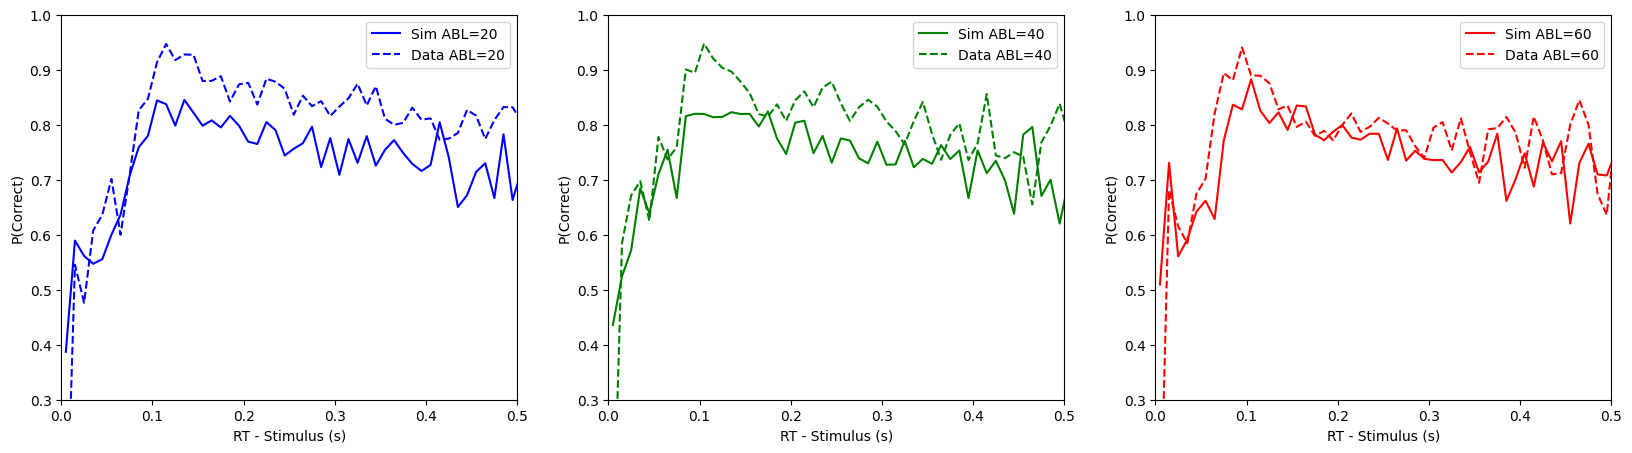

In [29]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

plt.figure(figsize=(20, 5))

ABL_values = np.sort(df_1['ABL'].unique())
colors = ['b', 'g', 'r']  # You can pick your own color scheme
a = 1
for abl_val, c in zip(ABL_values, colors):
    plt.subplot(1, len(ABL_values), a)
    # --- 1) Filter SIM dataframe for the given ABL value ---
    sim_sub = sim_results_valid_df[sim_results_valid_df['ABL'] == abl_val].copy()
    # Bin the RT values
    sim_sub['rt_bin'] = pd.cut(sim_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    sim_grouped = sim_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot SIM result (solid line)
    plt.plot(bin_centers, sim_grouped['correct'], 
            linestyle='-', 
            color=c, 
            label=f'Sim ABL={abl_val}')
    
    # --- 2) Filter DATA dataframe for the given ABL value ---
    data_sub = data_df[data_df['ABL'] == abl_val].copy()
    # Bin the RT values
    data_sub['rt_bin'] = pd.cut(data_sub['rt_wrt_stim'], bins=bins, right=False)
    # Group by bins, compute mean correctness
    data_grouped = data_sub.groupby('rt_bin', observed=False)['correct'].mean().reset_index()
    
    # Plot DATA result (dashed line)
    plt.plot(bin_centers, data_grouped['correct'], 
            linestyle='--', 
            color=c, 
            label=f'Data ABL={abl_val}')

        # Cosmetics
    plt.xlabel('RT - Stimulus (s)')
    plt.ylabel('P(Correct)')
    plt.ylim([0.3, 1])  # If you want to fix y-limits
    plt.xlim(0, 0.5)
    plt.legend()
    a += 1



# investigate second bump

Text(0.5, 0.98, 'Second Bump Data Distribution')

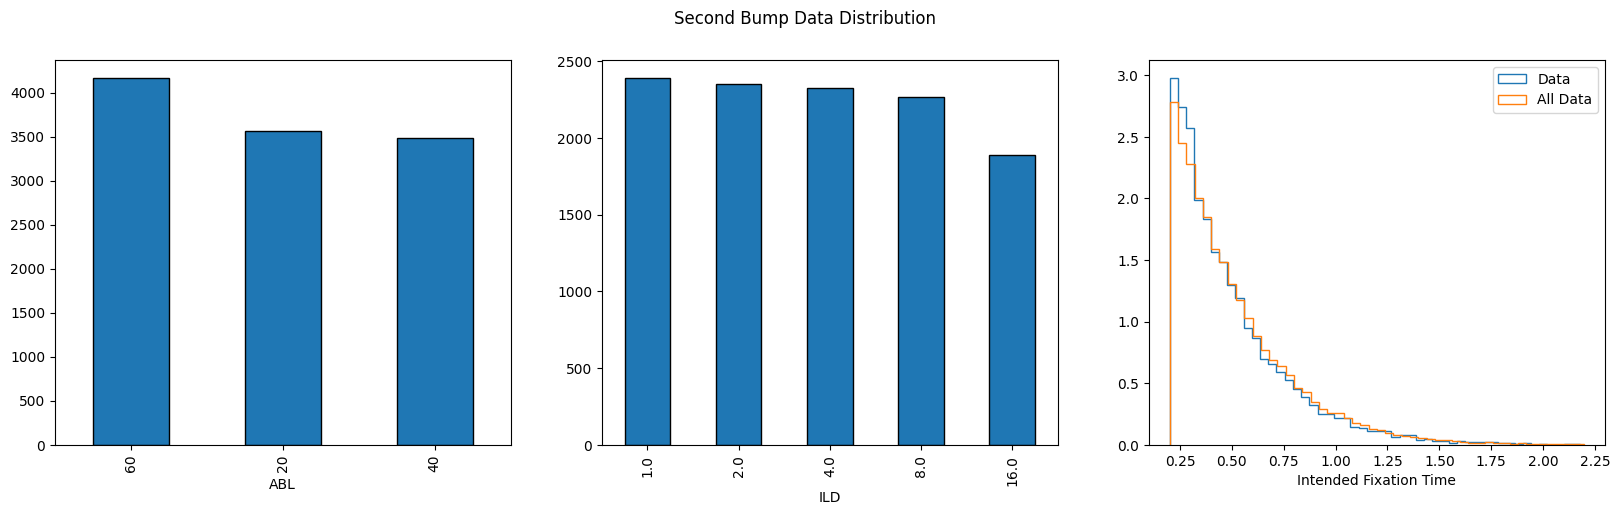

In [24]:
low_rt = 0.2
high_rt = 0.3

# Filter the dataframe based on that range:
df_second_bump = data_df[
    (data_df["rt_wrt_stim"] >= low_rt) & 
    (data_df["rt_wrt_stim"] <= high_rt)
]


plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
# plt.hist(df_second_bump["ABL"], bins=[20, 40, 60], label='Data')
counts = df_second_bump["ABL"].value_counts()
counts.plot(kind="bar", edgecolor="black")

plt.xlabel('ABL')

plt.subplot(1,3,2)
counts = np.abs(df_second_bump["ILD"]).value_counts()
counts.plot(kind="bar", edgecolor="black")
plt.xlabel('ILD')

plt.subplot(1,3,3)
plt.hist(df_second_bump["intended_fix"], bins=50, label='Data', histtype='step', density=True)
plt.hist(data_df["intended_fix"], bins=50, label='All Data', histtype='step', density=True)
plt.legend();
plt.xlabel('Intended Fixation Time')

plt.suptitle('Second Bump Data Distribution')

Text(0.5, 1.0, 'Abort event count of trial - 1 for second bump data btn 0.2 and 0.3 s')

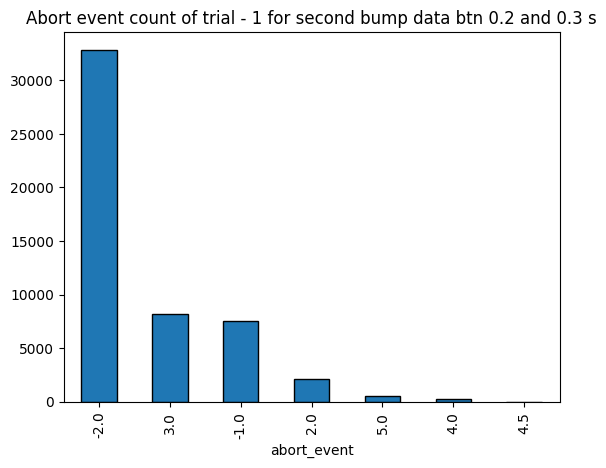

In [25]:
# Assuming `trial` column in df_second_bump contains integer values
# Create a list of trials minus 1
trial_minus_1 = df_second_bump['trial'] - 1

# Filter rows from df_1 where the trial column matches the values in trial_minus_1
filtered_df = og_df[og_df['trial'].isin(trial_minus_1)]

# Display the filtered dataframe
abort_event = filtered_df['abort_event']

abort_event_counts = abort_event.value_counts()
abort_event_counts.plot(kind="bar", edgecolor="black")
plt.title(f'Abort event count of trial - 1 for second bump data btn {low_rt} and {high_rt} s')

In [26]:
# Ensure the DataFrame index is reset to align with row positions
df = df.reset_index(drop=True)

# Create a mask to identify rows where the conditions are met
mask = df.apply(
    lambda row: (
        row['trial'] > 1  # Ensure trial-1 is a valid index
        and (row['trial'] - 1) in df.index  # Check trial-1 exists in the DataFrame index
        and df.iloc[int(row['trial']) - 1]['abort_event'] == 3  # Check abort_event in trial-1
        and row['ABL'] == df.iloc[int(row['trial']) - 1]['ABL']  # Match ABL with trial-1
        and row['ILD'] == df.iloc[int(row['trial']) - 1]['ILD']  # Match ILD with trial-1
        and row['success'] == 1
    ),
    axis=1
)

# Remove the rows that meet the condition
df_removed_repeats = df[~mask]


In [27]:
df_removed_repeats_led_off_valid_trials = df_removed_repeats[ (df_removed_repeats['LED_trial'] == 0) & \
                                                             (df_removed_repeats['success'] == 1) ]

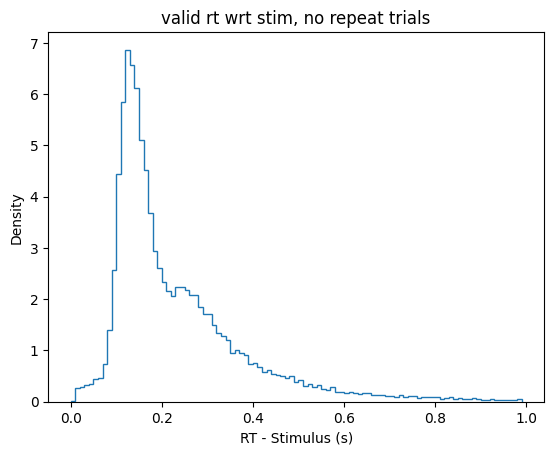

In [28]:
rt_wrt_stim_df_non_repeat = df_removed_repeats_led_off_valid_trials['timed_fix'] \
    - df_removed_repeats_led_off_valid_trials['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(rt_wrt_stim_df_non_repeat, bins=bins, density=True, histtype='step', label='data');
plt.title('valid rt wrt stim, no repeat trials')
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');



# see animal wise

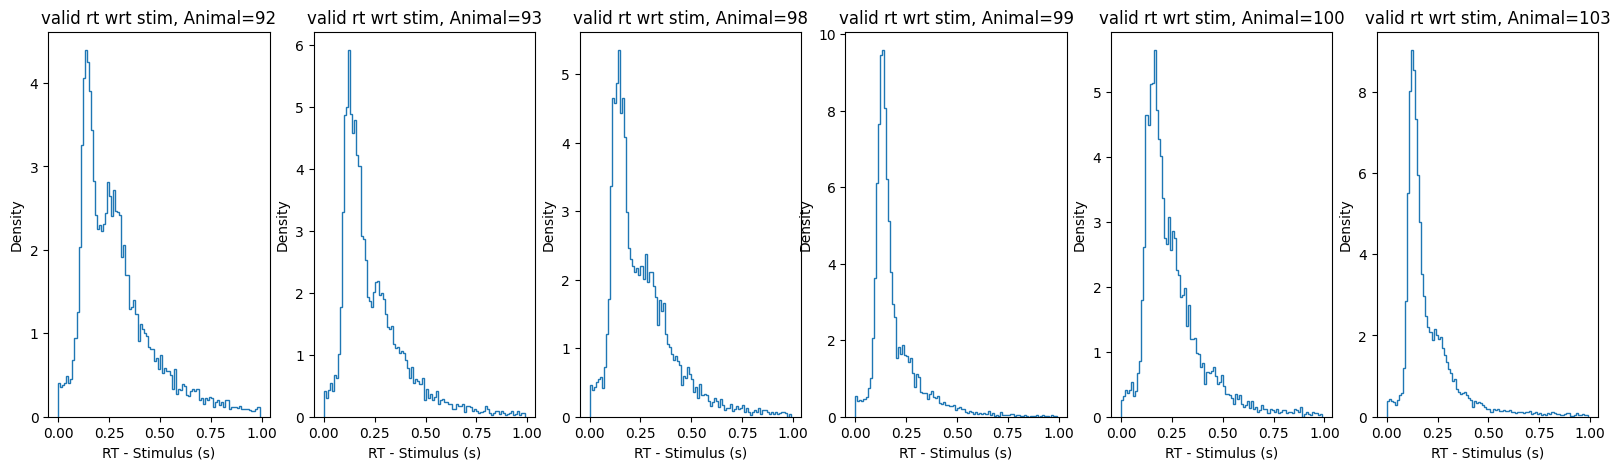

In [29]:
bins = np.arange(0, 1, 0.01)
bin_centers = bins[:-1] + (bins[1] - bins[0]) / 2

animals = df_1['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1

for animal in animals:
    animal_data = df_1[ df_1['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.title(f'valid rt wrt stim, Animal={animal}')
    a += 1


    

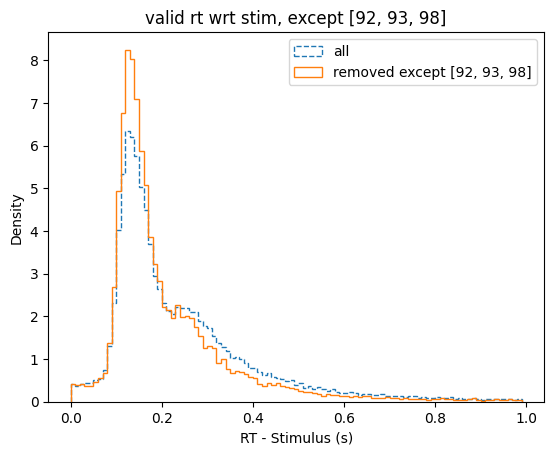

In [30]:
except_animals = [92, 93, 98]
df_1_except = df_1[ ~df_1['animal'].isin(except_animals) ]

df_1_except_animals_rt_wrt_stim = df_1_except['timed_fix'] - df_1_except['intended_fix']
df_1_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(df_1_rt_wrt_stim, bins=bins, density=True, histtype='step', label='all', ls='--');
plt.hist(df_1_except_animals_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'removed except {except_animals}');
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.title(f'valid rt wrt stim, except {except_animals}');
plt.legend();

# df led on also?

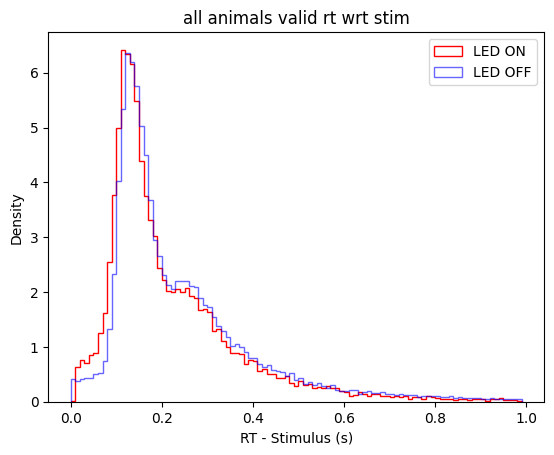

In [31]:
df_led_on = df [ df['LED_trial'] == 1 ]
df_led_on_valid_trials = df_led_on[ df_led_on['success'] == 1 ]
led_on_rt_wrt_stim = df_led_on_valid_trials['timed_fix'] - df_led_on_valid_trials['intended_fix']

led_off_rt_wrt_stim = df_1['timed_fix'] - df_1['intended_fix']

bins = np.arange(0, 1, 0.01)
plt.hist(led_on_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
plt.hist(led_off_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b', alpha=0.6);
plt.xlabel('RT - Stimulus (s)');
plt.ylabel('Density');
plt.legend();
plt.title('all animals valid rt wrt stim');

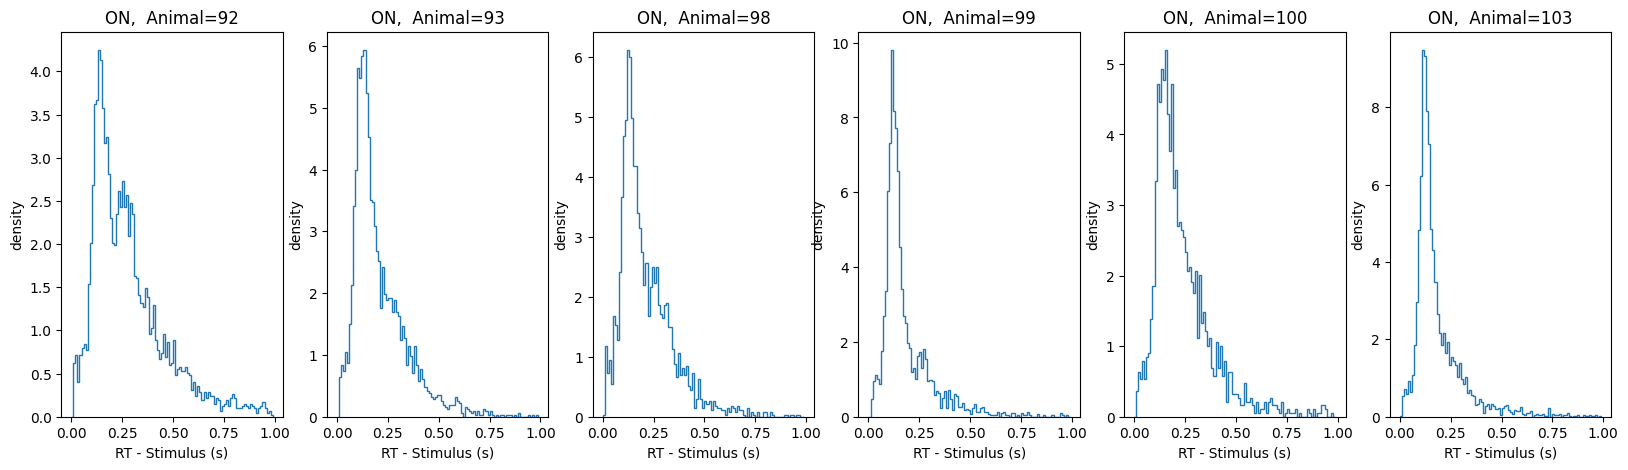

In [32]:
# animal wise LED on

animals = df_led_on['animal'].unique()
plt.figure(figsize=(20, 5))
a = 1
for animal in animals:
    animal_data = df_led_on_valid_trials[ df_led_on_valid_trials['animal'] == animal ]
    animal_rt_wrt_stim = animal_data['timed_fix'] - animal_data['intended_fix']
    plt.subplot(1, len(animals), a)
    plt.hist(animal_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ON,  Animal={animal}')
    a += 1
    

# plot RTs as func of ABL

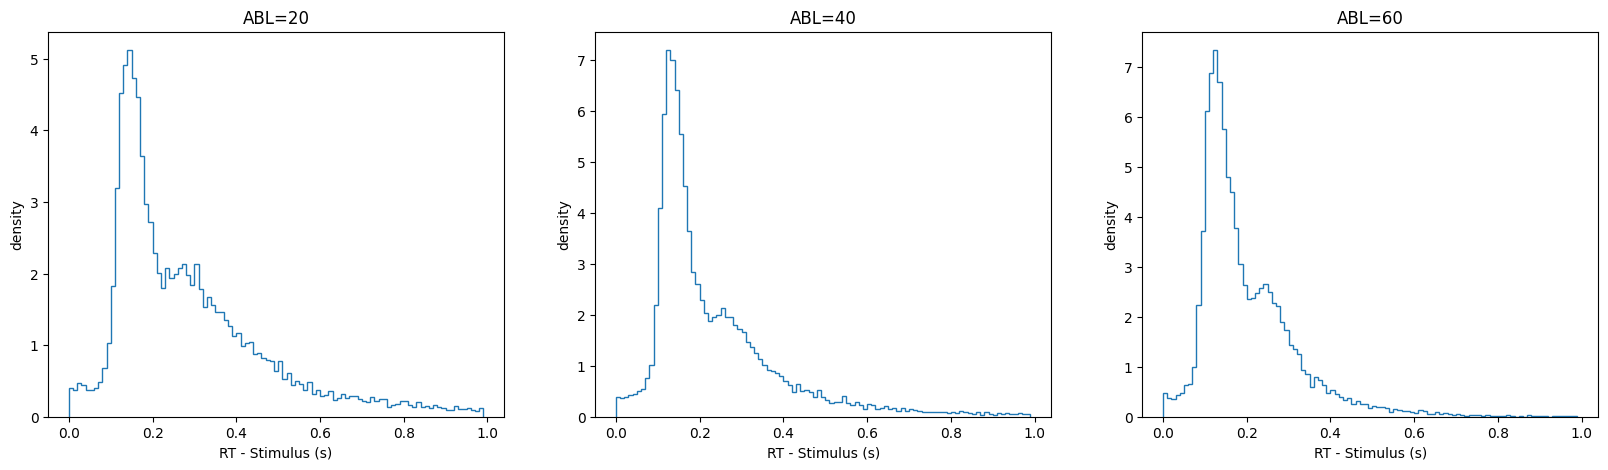

In [33]:
plt.figure(figsize=(20, 5))
a = 1
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
    plt.subplot(1, len(ABL_arr), a)
    plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label='data');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'ABL={ABL}')
    a += 1
    


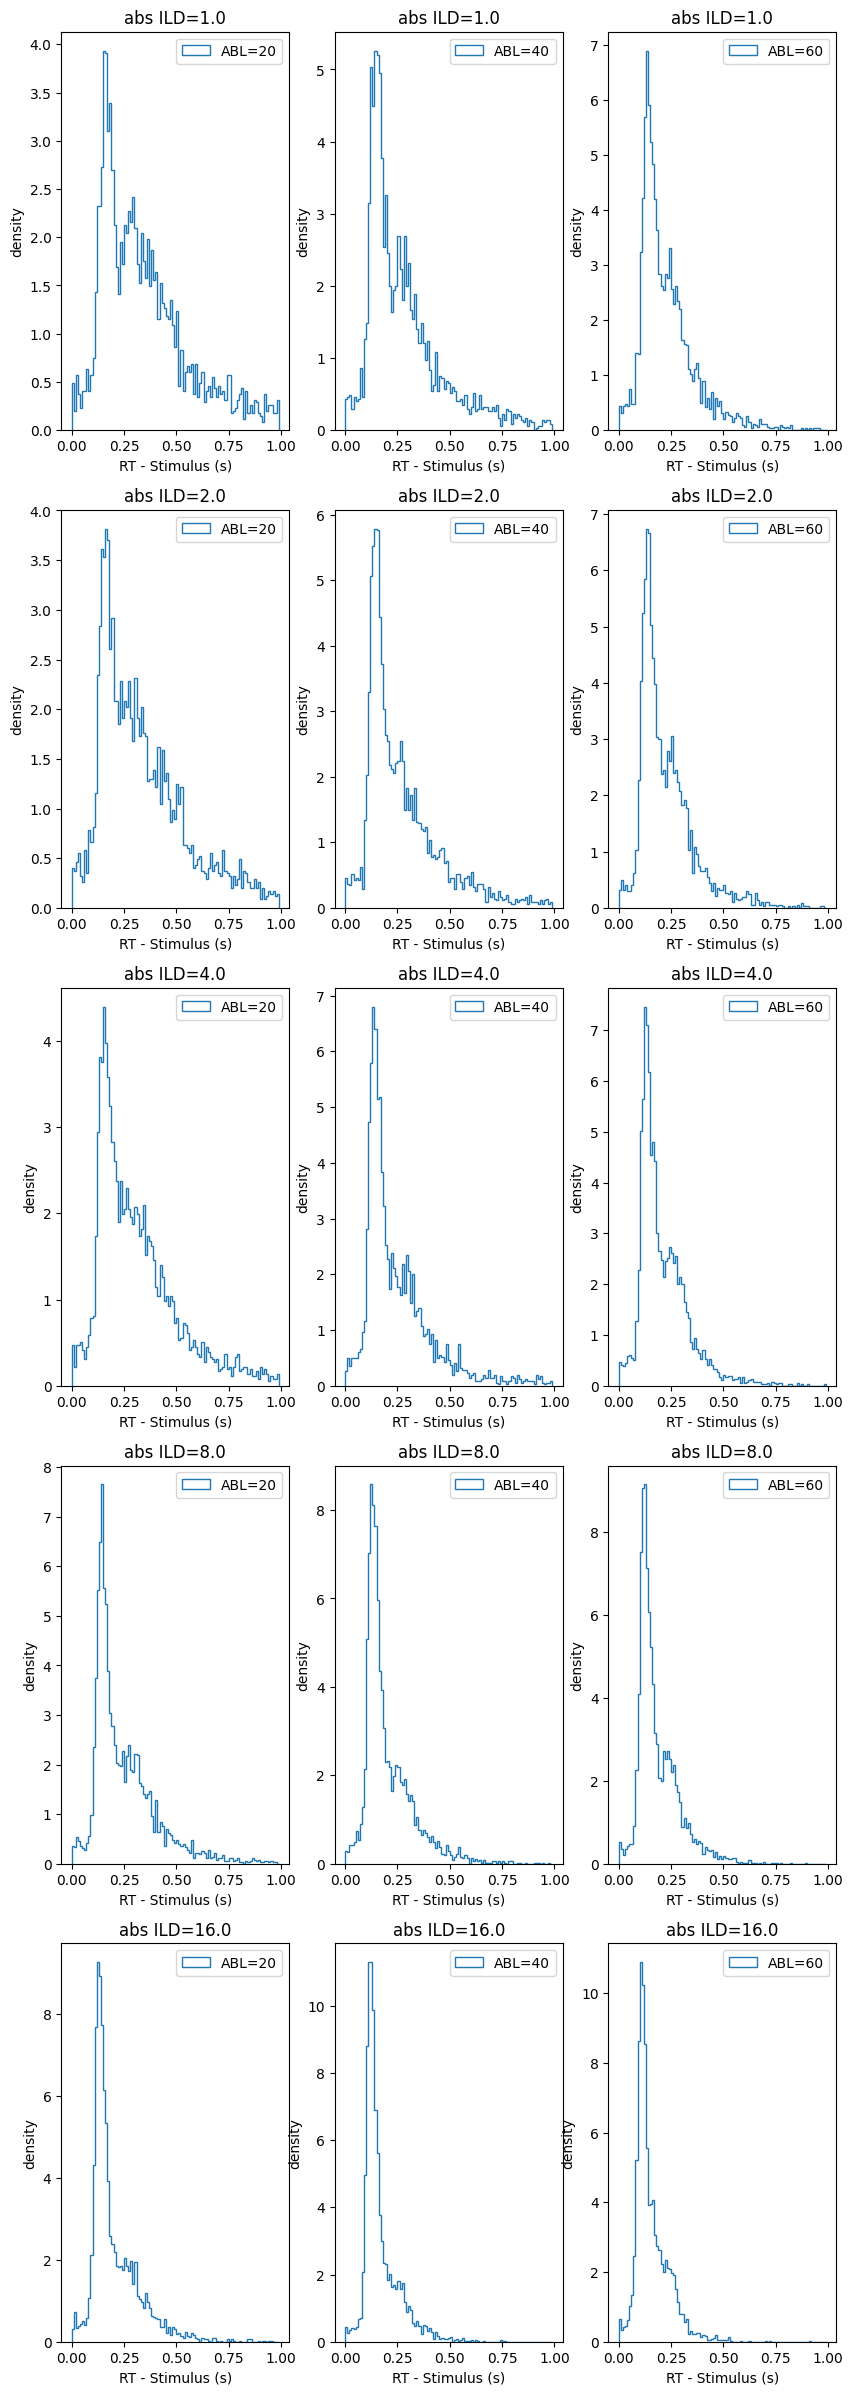

In [34]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,30))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    for ABL in ABL_arr:
        plt.subplot(5, 3, a)

        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
        plt.xlabel('RT - Stimulus (s)');
        plt.ylabel('density')
        plt.title(f'abs ILD={ILD}')
        plt.legend();
        a += 1

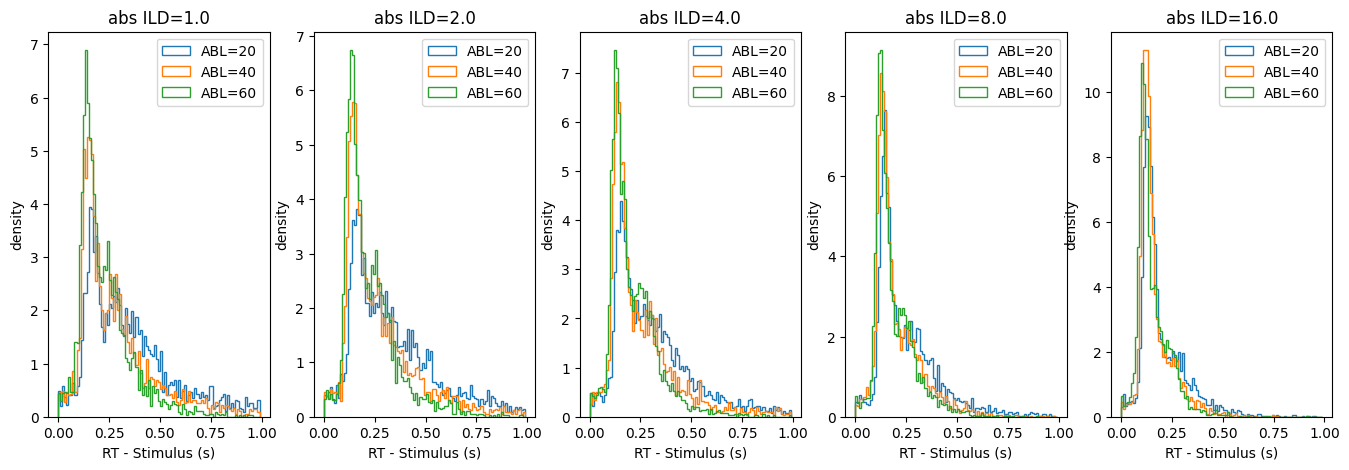

In [35]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(20,5))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ILD in pos_ILD:
    ILD_data = df_1[ (df_1['ILD'] == ILD) | (df_1['ILD'] == -ILD) ]
    plt.subplot(1,6, a)
    for ABL in ABL_arr:
        ABL_data = ILD_data[ ILD_data['ABL'] == ABL ]
        ABL_rt_wrt_stim = ABL_data['timed_fix'] - ABL_data['intended_fix']
        plt.hist(ABL_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ABL={ABL}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ILD={ILD}')
    plt.legend();
    a += 1

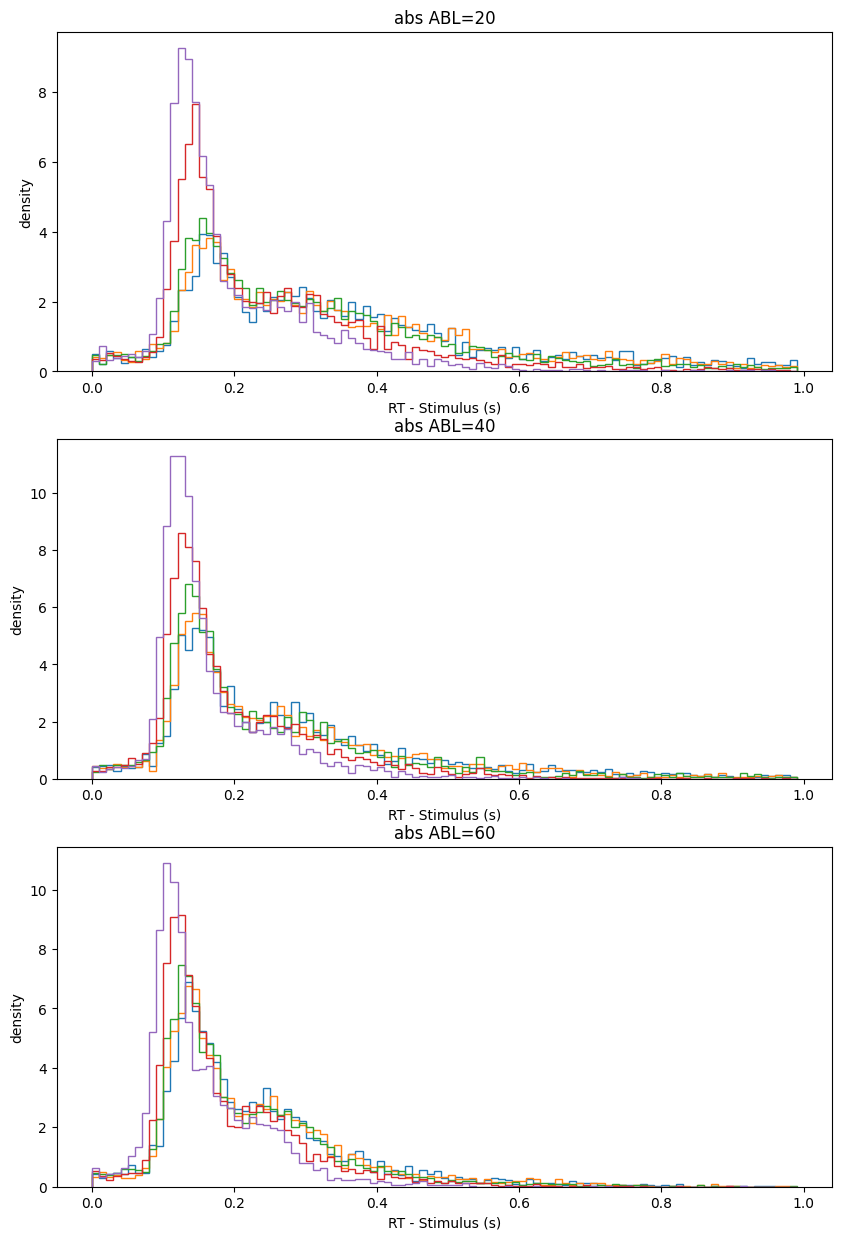

In [42]:
bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(10,15))
a = 1
pos_ILD = np.sort(np.unique(np.abs(ILD_arr)))
for ABL in ABL_arr:
    ABL_data = df_1[ df_1['ABL'] == ABL ]
    plt.subplot(3,1, a)
    for ILD in pos_ILD:
        ILD_data = ABL_data[ (ABL_data['ILD'] == ILD) | (ABL_data['ILD'] == -ILD) ]
        ILD_rt_wrt_stim = ILD_data['timed_fix'] - ILD_data['intended_fix']
        plt.hist(ILD_rt_wrt_stim, bins=bins, density=True, histtype='step', label=f'ILD={ILD}');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('density')
    plt.title(f'abs ABL={ABL}')
    a += 1

# all animals on and off

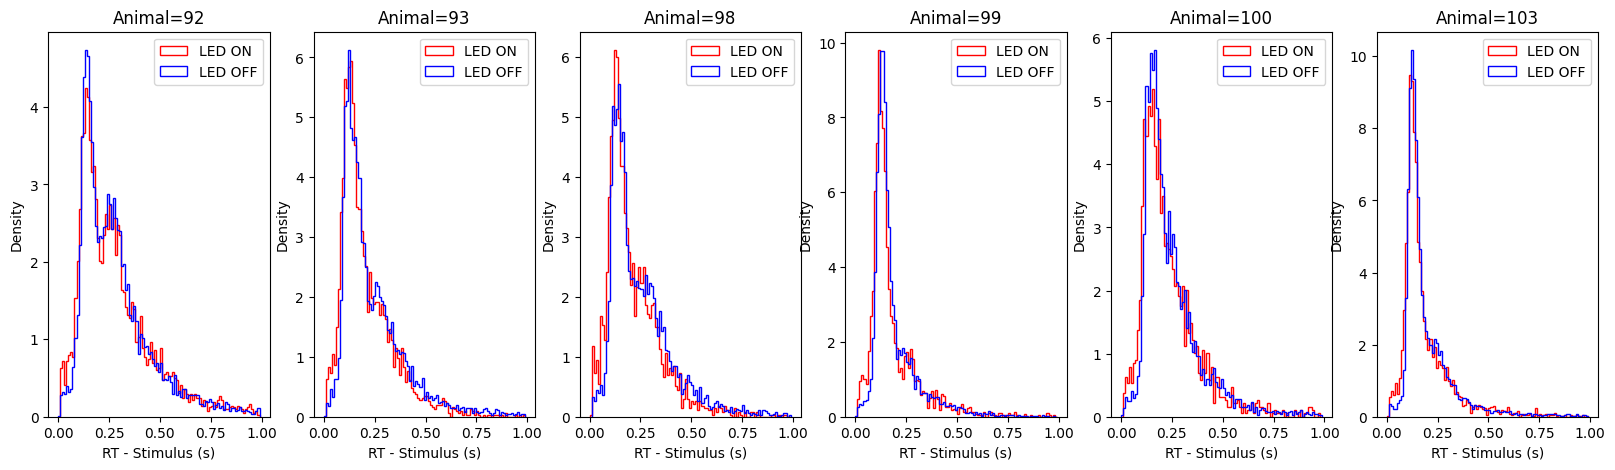

In [57]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']

    plt.subplot(1, len(animals), a)
    plt.hist(animal_on_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED ON', color='r');
    plt.hist(animal_off_valid_rt_wrt_stim, bins=bins, density=True, histtype='step', label='LED OFF', color='b');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1



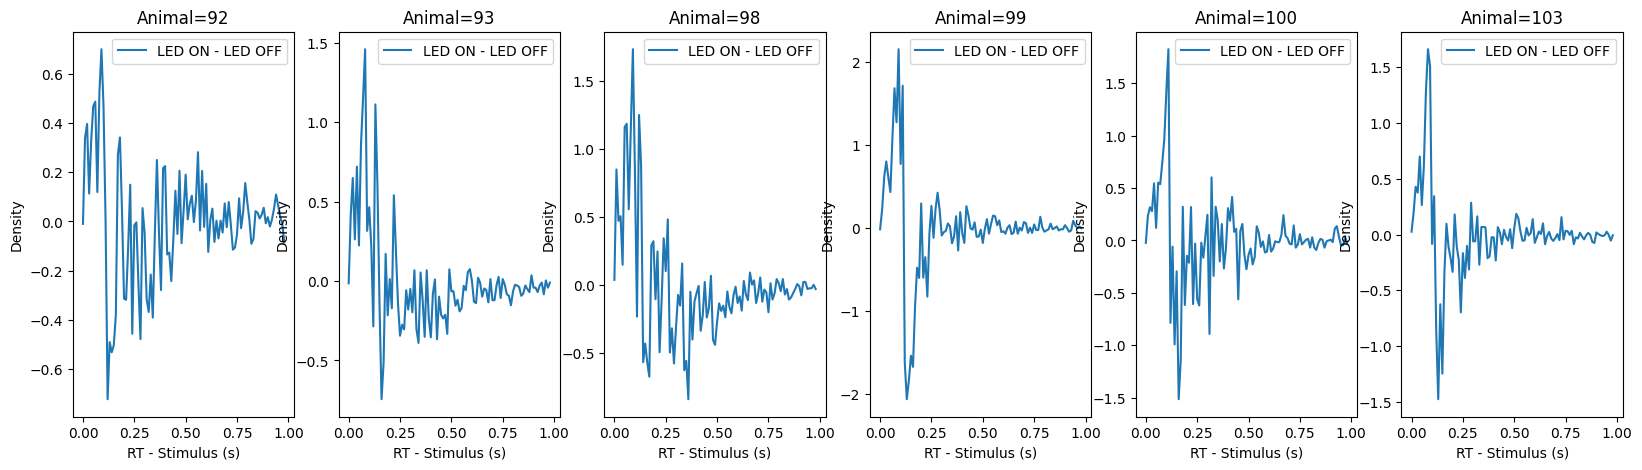

In [58]:
animals = df_1['animal'].unique()
a = 1
plt.figure(figsize=(20, 5))
for animal in animals:
    animal_data = df[ df['animal'] == animal ]
    animal_on = animal_data[ animal_data['LED_trial'] == 1 ]
    animal_off = animal_data[ animal_data['LED_trial'] == 0 ]

    animal_on_valid = animal_on[ animal_on['success'] == 1 ]
    animal_off_valid = animal_off[ animal_off['success'] == 1 ]

    animal_on_valid_rt_wrt_stim = animal_on_valid['timed_fix'] - animal_on_valid['intended_fix']
    animal_off_valid_rt_wrt_stim = animal_off_valid['timed_fix'] - animal_off_valid['intended_fix']
    plt.subplot(1, len(animals), a)
    # hist on - hist off
    hist_on, _ = np.histogram(animal_on_valid_rt_wrt_stim, bins=bins, density=True)
    hist_off, _ = np.histogram(animal_off_valid_rt_wrt_stim, bins=bins, density=True)

    plt.plot(bins[:-1], hist_on - hist_off, label='LED ON - LED OFF');
    plt.xlabel('RT - Stimulus (s)');
    plt.ylabel('Density');
    plt.legend();
    plt.title(f'Animal={animal}')

    a += 1

